## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

#### Import packages

In [1]:
import pandas
import numpy
import pickle
import sklearn
import sklearn.model_selection

# Graphs, visualizations
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tensorflow import keras
from keras.optimizers import Adam, SGD

# For Image Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

batch_size = 1024

In [2]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

list

In [54]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

def acc_plot(history):
    plt.plot(history.history['accuracy'], alpha=.6)
    plt.plot(history.history['val_accuracy'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    return plt

def loss_plot(history):
    plt.plot(history.history['loss'][1:], alpha=.6)
    plt.plot(history.history['val_loss'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    return plt
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pandas.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

def acc_df(histories):
    columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
    df = pandas.DataFrame(columns = columns)
    for history in histories:
    
    # get the epoch with the highest validation accuracy for each history element
        i = 0
        index = 0
        comp = 0
        for val_acc in history.history['val_accuracy']:
            if val_acc > comp:
                comp = val_acc
                i = index
            index += 1

        df_temp = pandas.DataFrame([[history.model.name,
                                  history.history['loss'][i],
                                  history.history['accuracy'][i],
                                  history.history['val_loss'][i],
                                  history.history['val_accuracy'][i]]], 
                        columns = columns)
        df = df.append(df_temp)

    df = df.set_index('model size')

    df = df.style.format({
        'loss': '{:,.2f}'.format,
        'accuracy': '{:,.2%}'.format,
        'val_loss': '{:,.2f}'.format,
        'val_accuracy': '{:,.2%}'.format,
    })

    return df

def plot_accuracies(histories, colors, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    
    i = 0
    colors=colors
    
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('train accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    i = 0
    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('test accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    

### Callbacks ###

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=20,
                       min_lr=1e-4,
                       verbose=2)

### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained

In [56]:
# Train-validation-test split
# 60% Train, 20% Test, 20% Validation 

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(numpy.asarray(X_data),
                                                                       numpy.asarray(y_data),
                                                                       test_size=.2,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.25,
                                                                     random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])

input_shape=x_train.shape[1:]
input_shape

(166514, 50, 50, 3) (166514,) 0.7144444310988866
(55505, 50, 50, 3) (55505,) 0.7182415998558689
(55505, 50, 50, 3) (55505,) 0.7189802720475633


(50, 50, 3)

### Simple Neural Network 

As a first network we:
- Flatten the input from the images
- Use one hidden layer with 64 neurons and a sigmoid activation function
- Use one sigmoid activation function for the ouput layer

## Test different learning rates

In [57]:
epochs = 1000
histories = []

name="1-layer-64-lr-0.00001"
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model1.save_weights('model.h5')
model1.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.00001), metrics=["accuracy"])
histories.append(model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.0001"
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model2.load_weights('model.h5')
model2.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.001"
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model3.load_weights('model.h5')
model3.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])
histories.append(model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.01"
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model4.load_weights('model.h5')
model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])
histories.append(model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))
hist0 = histories

Epoch 1/1000
163/163 [==============================] - 1s 6ms/step - loss: 36.5263 - accuracy: 0.6270 - val_loss: 7.4161 - val_accuracy: 0.3865
Epoch 2/1000
163/163 [==============================] - 1s 5ms/step - loss: 3.9761 - accuracy: 0.6740 - val_loss: 3.7331 - val_accuracy: 0.7320
Epoch 3/1000
163/163 [==============================] - 1s 5ms/step - loss: 2.2175 - accuracy: 0.6915 - val_loss: 1.1756 - val_accuracy: 0.7098
Epoch 4/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.0580 - accuracy: 0.6878 - val_loss: 0.9340 - val_accuracy: 0.7036
Epoch 5/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.8698 - accuracy: 0.6938 - val_loss: 0.7874 - val_accuracy: 0.7083
Epoch 6/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.7456 - accuracy: 0.7033 - val_loss: 0.6881 - val_accuracy: 0.7102
Epoch 7/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6629 - accuracy: 0.7130 - val_loss: 0.6261 - val_accuracy

163/163 [==============================] - 1s 5ms/step - loss: 0.4824 - accuracy: 0.7725 - val_loss: 0.4828 - val_accuracy: 0.7757
Epoch 58/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4819 - accuracy: 0.7727 - val_loss: 0.4818 - val_accuracy: 0.7730
Epoch 59/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4812 - accuracy: 0.7731 - val_loss: 0.4846 - val_accuracy: 0.7788
Epoch 60/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4806 - accuracy: 0.7737 - val_loss: 0.4812 - val_accuracy: 0.7772
Epoch 61/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4801 - accuracy: 0.7737 - val_loss: 0.4805 - val_accuracy: 0.7772
Epoch 62/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4795 - accuracy: 0.7743 - val_loss: 0.4798 - val_accuracy: 0.7770
Epoch 63/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4792 - accuracy: 0.7744 - val_loss: 0.4793 - val_accuracy: 0.7739

163/163 [==============================] - 1s 5ms/step - loss: 0.4620 - accuracy: 0.7855 - val_loss: 0.4643 - val_accuracy: 0.7823
Epoch 114/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4618 - accuracy: 0.7857 - val_loss: 0.4630 - val_accuracy: 0.7886
Epoch 115/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4616 - accuracy: 0.7856 - val_loss: 0.4634 - val_accuracy: 0.7835
Epoch 116/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4614 - accuracy: 0.7859 - val_loss: 0.4622 - val_accuracy: 0.7872
Epoch 117/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4611 - accuracy: 0.7862 - val_loss: 0.4620 - val_accuracy: 0.7859
Epoch 118/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4609 - accuracy: 0.7861 - val_loss: 0.4620 - val_accuracy: 0.7888
Epoch 119/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4608 - accuracy: 0.7862 - val_loss: 0.4619 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4483 - accuracy: 0.7949 - val_loss: 0.4507 - val_accuracy: 0.7949
Epoch 170/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4481 - accuracy: 0.7950 - val_loss: 0.4513 - val_accuracy: 0.7961
Epoch 171/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4478 - accuracy: 0.7953 - val_loss: 0.4506 - val_accuracy: 0.7959
Epoch 172/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4476 - accuracy: 0.7953 - val_loss: 0.4500 - val_accuracy: 0.7953
Epoch 173/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.4505 - val_accuracy: 0.7965
Epoch 174/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4471 - accuracy: 0.7961 - val_loss: 0.4503 - val_accuracy: 0.7965
Epoch 175/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4469 - accuracy: 0.7959 - val_loss: 0.4494 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4401 - accuracy: 0.8006 - val_loss: 0.4428 - val_accuracy: 0.7998
Epoch 226/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4400 - accuracy: 0.8004 - val_loss: 0.4427 - val_accuracy: 0.7998
Epoch 227/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4399 - accuracy: 0.8006 - val_loss: 0.4430 - val_accuracy: 0.8008
Epoch 228/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4398 - accuracy: 0.8004 - val_loss: 0.4428 - val_accuracy: 0.8008
Epoch 229/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4398 - accuracy: 0.8006 - val_loss: 0.4425 - val_accuracy: 0.8003
Epoch 230/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4396 - accuracy: 0.8007 - val_loss: 0.4423 - val_accuracy: 0.8002
Epoch 231/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4395 - accuracy: 0.8010 - val_loss: 0.4424 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4354 - accuracy: 0.8033 - val_loss: 0.4385 - val_accuracy: 0.8033
Epoch 282/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4354 - accuracy: 0.8035 - val_loss: 0.4387 - val_accuracy: 0.8032
Epoch 283/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4353 - accuracy: 0.8034 - val_loss: 0.4382 - val_accuracy: 0.8026
Epoch 284/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4352 - accuracy: 0.8034 - val_loss: 0.4385 - val_accuracy: 0.8032
Epoch 285/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4352 - accuracy: 0.8035 - val_loss: 0.4381 - val_accuracy: 0.8032 0.4357 - accuracy: 0.
Epoch 286/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4351 - accuracy: 0.8035 - val_loss: 0.4382 - val_accuracy: 0.8034
Epoch 287/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4350 - accuracy: 0.8037 - val_loss: 0

163/163 [==============================] - 1s 5ms/step - loss: 0.4319 - accuracy: 0.8050 - val_loss: 0.4354 - val_accuracy: 0.8054
Epoch 338/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4318 - accuracy: 0.8052 - val_loss: 0.4351 - val_accuracy: 0.8055
Epoch 339/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4318 - accuracy: 0.8051 - val_loss: 0.4349 - val_accuracy: 0.8050
Epoch 340/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4316 - accuracy: 0.8054 - val_loss: 0.4350 - val_accuracy: 0.8054
Epoch 341/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4316 - accuracy: 0.8055 - val_loss: 0.4350 - val_accuracy: 0.8053
Epoch 342/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4315 - accuracy: 0.8056 - val_loss: 0.4351 - val_accuracy: 0.8055
Epoch 343/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4315 - accuracy: 0.8055 - val_loss: 0.4347 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4289 - accuracy: 0.8069 - val_loss: 0.4324 - val_accuracy: 0.8068
Epoch 394/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4289 - accuracy: 0.8069 - val_loss: 0.4324 - val_accuracy: 0.8067
Epoch 395/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4288 - accuracy: 0.8069 - val_loss: 0.4323 - val_accuracy: 0.8070
Epoch 396/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4287 - accuracy: 0.8071 - val_loss: 0.4330 - val_accuracy: 0.8069
Epoch 397/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4287 - accuracy: 0.8073 - val_loss: 0.4324 - val_accuracy: 0.8070
Epoch 398/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4287 - accuracy: 0.8072 - val_loss: 0.4323 - val_accuracy: 0.8069
Epoch 399/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4287 - accuracy: 0.8075 - val_loss: 0.4321 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4264 - accuracy: 0.8083 - val_loss: 0.4302 - val_accuracy: 0.8083
Epoch 450/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8084 - val_loss: 0.4303 - val_accuracy: 0.8085
Epoch 451/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8085 - val_loss: 0.4301 - val_accuracy: 0.8083
Epoch 452/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8086 - val_loss: 0.4304 - val_accuracy: 0.8083
Epoch 453/1000
163/163 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.80 - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8088 - val_loss: 0.4301 - val_accuracy: 0.8083
Epoch 454/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4262 - accuracy: 0.8087 - val_loss: 0.4300 - val_accuracy: 0.8084
Epoch 455/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4261 - accuracy: 

Epoch 505/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4243 - accuracy: 0.8095 - val_loss: 0.4283 - val_accuracy: 0.8091
Epoch 506/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4243 - accuracy: 0.8096 - val_loss: 0.4286 - val_accuracy: 0.8092
Epoch 507/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4243 - accuracy: 0.8100 - val_loss: 0.4283 - val_accuracy: 0.8095
Epoch 508/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4243 - accuracy: 0.8098 - val_loss: 0.4285 - val_accuracy: 0.8094
Epoch 509/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4242 - accuracy: 0.8096 - val_loss: 0.4285 - val_accuracy: 0.8093
Epoch 510/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4242 - accuracy: 0.8097 - val_loss: 0.4281 - val_accuracy: 0.8095
Epoch 511/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4242 - accuracy: 0.8096 - val_loss: 0.4283 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4228 - accuracy: 0.8106 - val_loss: 0.4268 - val_accuracy: 0.8101
Epoch 561/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4227 - accuracy: 0.8106 - val_loss: 0.4272 - val_accuracy: 0.8102
Epoch 562/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4227 - accuracy: 0.8105 - val_loss: 0.4268 - val_accuracy: 0.8102
Epoch 563/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4227 - accuracy: 0.8104 - val_loss: 0.4268 - val_accuracy: 0.8102
Epoch 564/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4226 - accuracy: 0.8105 - val_loss: 0.4268 - val_accuracy: 0.8100
Epoch 565/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4226 - accuracy: 0.8104 - val_loss: 0.4267 - val_accuracy: 0.8105
Epoch 566/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4226 - accuracy: 0.8104 - val_loss: 0.4268 - val_accuracy: 

Epoch 616/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8111 - val_loss: 0.4257 - val_accuracy: 0.8106
Epoch 617/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4213 - accuracy: 0.8112 - val_loss: 0.4257 - val_accuracy: 0.8109
Epoch 618/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4213 - accuracy: 0.8110 - val_loss: 0.4260 - val_accuracy: 0.8106
Epoch 619/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4213 - accuracy: 0.8112 - val_loss: 0.4256 - val_accuracy: 0.8106
Epoch 620/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8111 - val_loss: 0.4254 - val_accuracy: 0.8109
Epoch 621/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8113 - val_loss: 0.4255 - val_accuracy: 0.8106
Epoch 622/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8112 - val_loss: 0.4260 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8119 - val_loss: 0.4244 - val_accuracy: 0.8110
Epoch 673/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8118 - val_loss: 0.4245 - val_accuracy: 0.8111
Epoch 674/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8117 - val_loss: 0.4244 - val_accuracy: 0.8115
Epoch 675/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8117 - val_loss: 0.4247 - val_accuracy: 0.8110
Epoch 676/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8118 - val_loss: 0.4244 - val_accuracy: 0.8114
Epoch 677/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4200 - accuracy: 0.8118 - val_loss: 0.4244 - val_accuracy: 0.8115
Epoch 678/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8121 - val_loss: 0.4244 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4191 - accuracy: 0.8123 - val_loss: 0.4235 - val_accuracy: 0.8118
Epoch 729/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8125 - val_loss: 0.4239 - val_accuracy: 0.8114
Epoch 730/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8126 - val_loss: 0.4237 - val_accuracy: 0.8119
Epoch 731/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8124 - val_loss: 0.4235 - val_accuracy: 0.8117
Epoch 732/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8127 - val_loss: 0.4235 - val_accuracy: 0.8116
Epoch 733/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8126 - val_loss: 0.4234 - val_accuracy: 0.8118
Epoch 734/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4190 - accuracy: 0.8124 - val_loss: 0.4235 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8130 - val_loss: 0.4232 - val_accuracy: 0.8118
Epoch 785/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8130 - val_loss: 0.4227 - val_accuracy: 0.8119
Epoch 786/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8130 - val_loss: 0.4227 - val_accuracy: 0.8120
Epoch 787/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8130 - val_loss: 0.4227 - val_accuracy: 0.8122
Epoch 788/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8128 - val_loss: 0.4227 - val_accuracy: 0.8121
Epoch 789/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8130 - val_loss: 0.4226 - val_accuracy: 0.8121
Epoch 790/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8130 - val_loss: 0.4227 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8136 - val_loss: 0.4222 - val_accuracy: 0.8124
Epoch 841/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8134 - val_loss: 0.4221 - val_accuracy: 0.8124
Epoch 842/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8134 - val_loss: 0.4224 - val_accuracy: 0.8125 0.4175 - accuracy: 0.
Epoch 843/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8133 - val_loss: 0.4219 - val_accuracy: 0.8124
Epoch 844/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8137 - val_loss: 0.4228 - val_accuracy: 0.8124
Epoch 845/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8134 - val_loss: 0.4223 - val_accuracy: 0.8125
Epoch 846/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8137 - val_loss: 0

163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8140 - val_loss: 0.4214 - val_accuracy: 0.8128
Epoch 897/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8139 - val_loss: 0.4217 - val_accuracy: 0.8129
Epoch 898/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8139 - val_loss: 0.4216 - val_accuracy: 0.8130
Epoch 899/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8137 - val_loss: 0.4213 - val_accuracy: 0.8126
Epoch 900/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8140 - val_loss: 0.4217 - val_accuracy: 0.8131
Epoch 901/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8141 - val_loss: 0.4214 - val_accuracy: 0.8130
Epoch 902/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8139 - val_loss: 0.4214 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4158 - accuracy: 0.8145 - val_loss: 0.4207 - val_accuracy: 0.8134
Epoch 952/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4158 - accuracy: 0.8144 - val_loss: 0.4207 - val_accuracy: 0.8134
Epoch 953/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4158 - accuracy: 0.8143 - val_loss: 0.4209 - val_accuracy: 0.8132
Epoch 954/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4158 - accuracy: 0.8143 - val_loss: 0.4207 - val_accuracy: 0.8133
Epoch 955/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4157 - accuracy: 0.8145 - val_loss: 0.4206 - val_accuracy: 0.8134
Epoch 956/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4157 - accuracy: 0.8144 - val_loss: 0.4207 - val_accuracy: 0.8134
Epoch 957/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4157 - accuracy: 0.8144 - val_loss: 0.4206 - val_accuracy: 

Epoch 7/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5003 - accuracy: 0.7442 - val_loss: 0.4960 - val_accuracy: 0.7561
Epoch 8/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4945 - accuracy: 0.7497 - val_loss: 0.4888 - val_accuracy: 0.7576
Epoch 9/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4898 - accuracy: 0.7547 - val_loss: 0.4847 - val_accuracy: 0.7625
Epoch 10/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4858 - accuracy: 0.7587 - val_loss: 0.4816 - val_accuracy: 0.7639
Epoch 11/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4824 - accuracy: 0.7628 - val_loss: 0.4783 - val_accuracy: 0.7701
Epoch 12/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4793 - accuracy: 0.7656 - val_loss: 0.4754 - val_accuracy: 0.7720
Epoch 13/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4765 - accuracy: 0.7683 - val_loss: 0.4744 - val_accur

163/163 [==============================] - 1s 5ms/step - loss: 0.4448 - accuracy: 0.8003 - val_loss: 0.4435 - val_accuracy: 0.8018
Epoch 64/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4445 - accuracy: 0.8004 - val_loss: 0.4431 - val_accuracy: 0.8033
Epoch 65/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4444 - accuracy: 0.8006 - val_loss: 0.4430 - val_accuracy: 0.8014
Epoch 66/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4443 - accuracy: 0.8009 - val_loss: 0.4429 - val_accuracy: 0.8024
Epoch 67/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4440 - accuracy: 0.8010 - val_loss: 0.4437 - val_accuracy: 0.8031
Epoch 68/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4438 - accuracy: 0.8011 - val_loss: 0.4443 - val_accuracy: 0.8015
Epoch 69/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4437 - accuracy: 0.8015 - val_loss: 0.4430 - val_accuracy: 0.8043

163/163 [==============================] - 1s 5ms/step - loss: 0.4372 - accuracy: 0.8084 - val_loss: 0.4368 - val_accuracy: 0.8099
Epoch 119/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4371 - accuracy: 0.8087 - val_loss: 0.4372 - val_accuracy: 0.8101
Epoch 120/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4370 - accuracy: 0.8089 - val_loss: 0.4366 - val_accuracy: 0.8106
Epoch 121/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4368 - accuracy: 0.8092 - val_loss: 0.4365 - val_accuracy: 0.8099
Epoch 122/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4368 - accuracy: 0.8092 - val_loss: 0.4364 - val_accuracy: 0.8100
Epoch 123/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4367 - accuracy: 0.8088 - val_loss: 0.4365 - val_accuracy: 0.8105
Epoch 124/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4366 - accuracy: 0.8090 - val_loss: 0.4363 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4327 - accuracy: 0.8123 - val_loss: 0.4331 - val_accuracy: 0.8125
Epoch 175/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4327 - accuracy: 0.8126 - val_loss: 0.4329 - val_accuracy: 0.8132
Epoch 176/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4325 - accuracy: 0.8127 - val_loss: 0.4331 - val_accuracy: 0.8134
Epoch 177/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4324 - accuracy: 0.8128 - val_loss: 0.4330 - val_accuracy: 0.8136
Epoch 178/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4324 - accuracy: 0.8127 - val_loss: 0.4326 - val_accuracy: 0.8135
Epoch 179/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4323 - accuracy: 0.8128 - val_loss: 0.4346 - val_accuracy: 0.8137
Epoch 180/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4323 - accuracy: 0.8128 - val_loss: 0.4325 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4293 - accuracy: 0.8150 - val_loss: 0.4301 - val_accuracy: 0.8146
Epoch 230/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4292 - accuracy: 0.8147 - val_loss: 0.4308 - val_accuracy: 0.8152
Epoch 231/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4292 - accuracy: 0.8149 - val_loss: 0.4299 - val_accuracy: 0.8149
Epoch 232/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4292 - accuracy: 0.8147 - val_loss: 0.4298 - val_accuracy: 0.8150
Epoch 233/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4291 - accuracy: 0.8147 - val_loss: 0.4306 - val_accuracy: 0.8141
Epoch 234/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4290 - accuracy: 0.8149 - val_loss: 0.4299 - val_accuracy: 0.8148
Epoch 235/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4290 - accuracy: 0.8149 - val_loss: 0.4296 - val_accuracy: 

Epoch 285/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4265 - accuracy: 0.8163 - val_loss: 0.4278 - val_accuracy: 0.8158
Epoch 286/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4264 - accuracy: 0.8164 - val_loss: 0.4281 - val_accuracy: 0.8155
Epoch 287/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8163 - val_loss: 0.4284 - val_accuracy: 0.8165
Epoch 288/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8165 - val_loss: 0.4275 - val_accuracy: 0.8161
Epoch 289/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4263 - accuracy: 0.8165 - val_loss: 0.4275 - val_accuracy: 0.8166
Epoch 290/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4262 - accuracy: 0.8166 - val_loss: 0.4275 - val_accuracy: 0.8155
Epoch 291/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4262 - accuracy: 0.8167 - val_loss: 0.4275 -

Epoch 341/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4240 - accuracy: 0.8177 - val_loss: 0.4258 - val_accuracy: 0.8164
Epoch 342/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4240 - accuracy: 0.8177 - val_loss: 0.4256 - val_accuracy: 0.8171
Epoch 343/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4239 - accuracy: 0.8177 - val_loss: 0.4255 - val_accuracy: 0.8164
Epoch 344/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8176 - val_loss: 0.4255 - val_accuracy: 0.8172
Epoch 345/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8177 - val_loss: 0.4263 - val_accuracy: 0.8172
Epoch 346/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4237 - accuracy: 0.8179 - val_loss: 0.4254 - val_accuracy: 0.8172
Epoch 347/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4237 - accuracy: 0.8177 - val_loss: 0.4255 -

Epoch 397/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8184 - val_loss: 0.4237 - val_accuracy: 0.8173
Epoch 398/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8185 - val_loss: 0.4240 - val_accuracy: 0.8176
Epoch 399/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8186 - val_loss: 0.4238 - val_accuracy: 0.8177
Epoch 400/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8186 - val_loss: 0.4239 - val_accuracy: 0.8175
Epoch 401/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4216 - accuracy: 0.8187 - val_loss: 0.4236 - val_accuracy: 0.8177
Epoch 402/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4216 - accuracy: 0.8188 - val_loss: 0.4234 - val_accuracy: 0.8170
Epoch 403/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4215 - accuracy: 0.8184 - val_loss: 0.4234 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4197 - accuracy: 0.8191 - val_loss: 0.4221 - val_accuracy: 0.8179
Epoch 454/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4197 - accuracy: 0.8193 - val_loss: 0.4223 - val_accuracy: 0.8177
Epoch 455/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4196 - accuracy: 0.8193 - val_loss: 0.4221 - val_accuracy: 0.8177 - loss: 0.4197 - accuracy: 0.
Epoch 456/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4197 - accuracy: 0.8195 - val_loss: 0.4220 - val_accuracy: 0.8178
Epoch 457/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4196 - accuracy: 0.8192 - val_loss: 0.4218 - val_accuracy: 0.8180
Epoch 458/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4196 - accuracy: 0.8195 - val_loss: 0.4219 - val_accuracy: 0.8181
Epoch 459/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8192 - val

163/163 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.8199 - val_loss: 0.4206 - val_accuracy: 0.8188
Epoch 510/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.8198 - val_loss: 0.4208 - val_accuracy: 0.8184
Epoch 511/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.8202 - val_loss: 0.4208 - val_accuracy: 0.8183
Epoch 512/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4178 - accuracy: 0.8200 - val_loss: 0.4204 - val_accuracy: 0.8186
Epoch 513/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4178 - accuracy: 0.8201 - val_loss: 0.4204 - val_accuracy: 0.8186
Epoch 514/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8201 - val_loss: 0.4203 - val_accuracy: 0.8183
Epoch 515/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8201 - val_loss: 0.4207 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4162 - accuracy: 0.8204 - val_loss: 0.4192 - val_accuracy: 0.8190
Epoch 566/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4162 - accuracy: 0.8205 - val_loss: 0.4197 - val_accuracy: 0.8191
Epoch 567/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8205 - val_loss: 0.4191 - val_accuracy: 0.8192
Epoch 568/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8206 - val_loss: 0.4194 - val_accuracy: 0.8191
Epoch 569/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4162 - accuracy: 0.8204 - val_loss: 0.4191 - val_accuracy: 0.8192
Epoch 570/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4160 - accuracy: 0.8205 - val_loss: 0.4191 - val_accuracy: 0.8193
Epoch 571/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8203 - val_loss: 0.4192 - val_accuracy: 

Epoch 621/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4147 - accuracy: 0.8208 - val_loss: 0.4184 - val_accuracy: 0.8196
Epoch 622/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4146 - accuracy: 0.8207 - val_loss: 0.4182 - val_accuracy: 0.8194
Epoch 623/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4146 - accuracy: 0.8208 - val_loss: 0.4180 - val_accuracy: 0.8195
Epoch 624/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8210 - val_loss: 0.4184 - val_accuracy: 0.8190
Epoch 625/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8209 - val_loss: 0.4182 - val_accuracy: 0.8192
Epoch 626/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8208 - val_loss: 0.4180 - val_accuracy: 0.8194
Epoch 627/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8209 - val_loss: 0.4182 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4132 - accuracy: 0.8213 - val_loss: 0.4169 - val_accuracy: 0.8198
Epoch 678/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4132 - accuracy: 0.8215 - val_loss: 0.4171 - val_accuracy: 0.8196
Epoch 679/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4132 - accuracy: 0.8212 - val_loss: 0.4170 - val_accuracy: 0.8200
Epoch 680/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4132 - accuracy: 0.8213 - val_loss: 0.4170 - val_accuracy: 0.8196
Epoch 681/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4131 - accuracy: 0.8212 - val_loss: 0.4177 - val_accuracy: 0.8199
Epoch 682/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4131 - accuracy: 0.8214 - val_loss: 0.4168 - val_accuracy: 0.8202
Epoch 683/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4130 - accuracy: 0.8211 - val_loss: 0.4168 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4119 - accuracy: 0.8220 - val_loss: 0.4158 - val_accuracy: 0.8204
Epoch 734/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4118 - accuracy: 0.8216 - val_loss: 0.4158 - val_accuracy: 0.8200
Epoch 735/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4118 - accuracy: 0.8216 - val_loss: 0.4158 - val_accuracy: 0.8199
Epoch 736/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4118 - accuracy: 0.8213 - val_loss: 0.4161 - val_accuracy: 0.8197
Epoch 737/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8217 - val_loss: 0.4159 - val_accuracy: 0.8204
Epoch 738/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8217 - val_loss: 0.4157 - val_accuracy: 0.8200
Epoch 739/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8216 - val_loss: 0.4157 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4105 - accuracy: 0.8219 - val_loss: 0.4152 - val_accuracy: 0.8204
Epoch 790/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4105 - accuracy: 0.8223 - val_loss: 0.4151 - val_accuracy: 0.8204
Epoch 791/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4105 - accuracy: 0.8223 - val_loss: 0.4155 - val_accuracy: 0.8203
Epoch 792/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4105 - accuracy: 0.8219 - val_loss: 0.4149 - val_accuracy: 0.8204
Epoch 793/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4105 - accuracy: 0.8218 - val_loss: 0.4150 - val_accuracy: 0.8205
Epoch 794/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4105 - accuracy: 0.8222 - val_loss: 0.4149 - val_accuracy: 0.8202 - loss: 0.4119 - accura
Epoch 795/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4104 - accuracy: 0.8221 - val_loss:

163/163 [==============================] - 1s 5ms/step - loss: 0.4094 - accuracy: 0.8223 - val_loss: 0.4145 - val_accuracy: 0.8203
Epoch 846/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8223 - val_loss: 0.4145 - val_accuracy: 0.8204
Epoch 847/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8226 - val_loss: 0.4155 - val_accuracy: 0.8203
Epoch 848/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4092 - accuracy: 0.8224 - val_loss: 0.4142 - val_accuracy: 0.8206
Epoch 849/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8223 - val_loss: 0.4141 - val_accuracy: 0.8203oss: 0.4096 - accuracy: 0.82
Epoch 850/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8225 - val_loss: 0.4140 - val_accuracy: 0.8206
Epoch 851/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4092 - accuracy: 0.8225 - val_l

163/163 [==============================] - 1s 5ms/step - loss: 0.4082 - accuracy: 0.8227 - val_loss: 0.4140 - val_accuracy: 0.8207
Epoch 901/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4081 - accuracy: 0.8229 - val_loss: 0.4136 - val_accuracy: 0.8200
Epoch 902/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4081 - accuracy: 0.8227 - val_loss: 0.4137 - val_accuracy: 0.8206
Epoch 903/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4082 - accuracy: 0.8228 - val_loss: 0.4134 - val_accuracy: 0.8206
Epoch 904/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4081 - accuracy: 0.8230 - val_loss: 0.4133 - val_accuracy: 0.8209
Epoch 905/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4082 - accuracy: 0.8230 - val_loss: 0.4135 - val_accuracy: 0.8206 - loss: 0.4082 - accuracy: 0.82
Epoch 906/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4081 - accuracy: 0.8227 - v

163/163 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8235 - val_loss: 0.4128 - val_accuracy: 0.8208
Epoch 956/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8232 - val_loss: 0.4128 - val_accuracy: 0.8202
Epoch 957/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4070 - accuracy: 0.8230 - val_loss: 0.4128 - val_accuracy: 0.8210
Epoch 958/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8233 - val_loss: 0.4127 - val_accuracy: 0.8209
Epoch 959/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4070 - accuracy: 0.8232 - val_loss: 0.4130 - val_accuracy: 0.8210
Epoch 960/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4070 - accuracy: 0.8233 - val_loss: 0.4132 - val_accuracy: 0.8210
Epoch 961/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4070 - accuracy: 0.8234 - val_loss: 0.4126 - val_accuracy: 

Epoch 11/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6400 - accuracy: 0.7144 - val_loss: 0.6373 - val_accuracy: 0.7190
Epoch 12/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6368 - accuracy: 0.7144 - val_loss: 0.6343 - val_accuracy: 0.7190
Epoch 13/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6340 - accuracy: 0.7144 - val_loss: 0.6314 - val_accuracy: 0.7190
Epoch 14/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6314 - accuracy: 0.7144 - val_loss: 0.6287 - val_accuracy: 0.7190
Epoch 15/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6288 - accuracy: 0.7144 - val_loss: 0.6263 - val_accuracy: 0.7190
Epoch 16/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6266 - accuracy: 0.7144 - val_loss: 0.6242 - val_accuracy: 0.7190
Epoch 17/1000
163/163 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.71 - 1s 5ms/step - loss: 0.6245 - ac

163/163 [==============================] - 1s 5ms/step - loss: 0.5987 - accuracy: 0.7144 - val_loss: 0.5956 - val_accuracy: 0.7189
Epoch 67/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5988 - accuracy: 0.7144 - val_loss: 0.5956 - val_accuracy: 0.7189
Epoch 68/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5988 - accuracy: 0.7144 - val_loss: 0.5955 - val_accuracy: 0.7189
Epoch 69/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5987 - accuracy: 0.7144 - val_loss: 0.5953 - val_accuracy: 0.7189
Epoch 70/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5987 - accuracy: 0.7144 - val_loss: 0.5953 - val_accuracy: 0.7189
Epoch 71/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5986 - accuracy: 0.7144 - val_loss: 0.5953 - val_accuracy: 0.7189
Epoch 72/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5986 - accuracy: 0.7144 - val_loss: 0.5952 - val_accuracy: 0.7189

163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7190
Epoch 123/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 124/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 125/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7190
Epoch 126/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7190
Epoch 127/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 128/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 179/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 180/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5947 - val_accuracy: 0.7189
Epoch 181/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 182/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 183/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 184/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 0.7190
Epoch 235/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 236/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7190
Epoch 237/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 238/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 239/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 0.7190
Epoch 240/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5947 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 290/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7144 - val_loss: 0.5947 - val_accuracy: 0.7190
Epoch 291/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 0.7190
Epoch 292/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 0.7190
Epoch 293/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 294/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 0.7190
Epoch 295/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 0.7190
Epoch 346/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7144 - val_loss: 0.5969 - val_accuracy: 0.7190
Epoch 347/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 348/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7144 - val_loss: 0.5919 - val_accuracy: 0.7190
Epoch 349/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7144 - val_loss: 0.5949 - val_accuracy: 0.7190
Epoch 350/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7144 - val_loss: 0.5948 - val_accuracy: 0.7190
Epoch 351/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7144 - val_loss: 0.5948 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 402/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 0.7190
Epoch 403/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7190
Epoch 404/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 0.7190
Epoch 405/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5947 - val_accuracy: 0.7190
Epoch 406/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7190
Epoch 407/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 

Epoch 457/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 458/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5975 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 459/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 460/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 461/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 0.7190
Epoch 462/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 463/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.7144 - val_loss: 0.5941 -

163/163 [==============================] - 1s 6ms/step - loss: 0.5972 - accuracy: 0.7144 - val_loss: 0.5947 - val_accuracy: 0.7190
Epoch 514/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 515/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7190
Epoch 516/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7144 - val_loss: 0.5944 - val_accuracy: 0.7190
Epoch 517/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7144 - val_loss: 0.5941 - val_accuracy: 0.7190
Epoch 518/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7190
Epoch 519/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7144 - val_loss: 0.5946 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 569/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 570/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 571/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 572/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 573/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 574/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7144 - val_loss: 0.5943 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5711 - accuracy: 0.7144 - val_loss: 0.5390 - val_accuracy: 0.7189
Epoch 625/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5627 - accuracy: 0.7144 - val_loss: 0.5322 - val_accuracy: 0.7189
Epoch 626/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5731 - accuracy: 0.7144 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 627/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5732 - accuracy: 0.7144 - val_loss: 0.5904 - val_accuracy: 0.7189
Epoch 628/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5600 - accuracy: 0.7144 - val_loss: 0.5743 - val_accuracy: 0.7189
Epoch 629/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5678 - accuracy: 0.7144 - val_loss: 0.5232 - val_accuracy: 0.7189
Epoch 630/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5591 - accuracy: 0.7144 - val_loss: 0.5701 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5033 - accuracy: 0.7144 - val_loss: 0.4640 - val_accuracy: 0.7189 loss: 0.5061 - accuracy: 0.
Epoch 680/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5051 - accuracy: 0.7144 - val_loss: 0.4633 - val_accuracy: 0.7189
Epoch 681/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5030 - accuracy: 0.7144 - val_loss: 0.5463 - val_accuracy: 0.7189
Epoch 682/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5047 - accuracy: 0.7144 - val_loss: 0.4687 - val_accuracy: 0.7189
Epoch 683/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5096 - accuracy: 0.7144 - val_loss: 0.4624 - val_accuracy: 0.7189
Epoch 684/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5081 - accuracy: 0.7144 - val_loss: 0.4836 - val_accuracy: 0.7189
Epoch 685/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5069 - accuracy: 0.7144 - val_l

Epoch 735/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4990 - accuracy: 0.7144 - val_loss: 0.5600 - val_accuracy: 0.7190
Epoch 736/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5000 - accuracy: 0.7144 - val_loss: 0.4973 - val_accuracy: 0.7190
Epoch 737/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5033 - accuracy: 0.7144 - val_loss: 0.4871 - val_accuracy: 0.7190 - loss: 0.5046 - accuracy: 
Epoch 738/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5073 - accuracy: 0.7144 - val_loss: 0.4760 - val_accuracy: 0.7190
Epoch 739/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4967 - accuracy: 0.7144 - val_loss: 0.4657 - val_accuracy: 0.7190
Epoch 740/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5038 - accuracy: 0.7144 - val_loss: 0.6107 - val_accuracy: 0.7189
Epoch 741/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4973 - accuracy:

Epoch 791/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5036 - accuracy: 0.7125 - val_loss: 0.4550 - val_accuracy: 0.7190
Epoch 792/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4968 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 793/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5441 - accuracy: 0.7144 - val_loss: 0.5124 - val_accuracy: 0.7190
Epoch 794/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4957 - accuracy: 0.7144 - val_loss: 0.4527 - val_accuracy: 0.7190
Epoch 795/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5028 - accuracy: 0.7144 - val_loss: 0.4876 - val_accuracy: 0.7190
Epoch 796/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5051 - accuracy: 0.7144 - val_loss: 0.5244 - val_accuracy: 0.7190
Epoch 797/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5102 - accuracy: 0.7144 - val_loss: 0.5455 -

Epoch 847/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4930 - accuracy: 0.7144 - val_loss: 0.4877 - val_accuracy: 0.7190
Epoch 848/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4943 - accuracy: 0.7144 - val_loss: 0.4727 - val_accuracy: 0.7190
Epoch 849/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4919 - accuracy: 0.7144 - val_loss: 0.4661 - val_accuracy: 0.7190
Epoch 850/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4952 - accuracy: 0.7144 - val_loss: 0.4606 - val_accuracy: 0.7190
Epoch 851/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5233 - accuracy: 0.7144 - val_loss: 0.5671 - val_accuracy: 0.7190
Epoch 852/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5243 - accuracy: 0.7144 - val_loss: 0.6548 - val_accuracy: 0.7190
Epoch 853/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5006 - accuracy: 0.7144 - val_loss: 0.5185 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5048 - accuracy: 0.7122 - val_loss: 0.4684 - val_accuracy: 0.7190
Epoch 904/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5028 - accuracy: 0.7122 - val_loss: 0.5302 - val_accuracy: 0.7190
Epoch 905/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4951 - accuracy: 0.7144 - val_loss: 0.5022 - val_accuracy: 0.7190
Epoch 906/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5451 - accuracy: 0.7144 - val_loss: 0.5176 - val_accuracy: 0.7190
Epoch 907/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5000 - accuracy: 0.7144 - val_loss: 0.5033 - val_accuracy: 0.7190
Epoch 908/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4940 - accuracy: 0.7144 - val_loss: 0.5339 - val_accuracy: 0.7190
Epoch 909/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4932 - accuracy: 0.7144 - val_loss: 0.5668 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5499 - accuracy: 0.7144 - val_loss: 0.6580 - val_accuracy: 0.7190
Epoch 960/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5017 - accuracy: 0.7144 - val_loss: 0.4545 - val_accuracy: 0.7190
Epoch 961/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4926 - accuracy: 0.7144 - val_loss: 0.5254 - val_accuracy: 0.7190
Epoch 962/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.4908 - accuracy: 0.7144 - val_loss: 0.4705 - val_accuracy: 0.7190
Epoch 963/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4953 - accuracy: 0.7144 - val_loss: 0.4939 - val_accuracy: 0.7190
Epoch 964/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4880 - accuracy: 0.7144 - val_loss: 0.6018 - val_accuracy: 0.7190
Epoch 965/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4915 - accuracy: 0.7144 - val_loss: 0.5339 - val_accuracy: 

Epoch 15/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 16/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 17/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 18/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 19/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 20/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 21/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_ac

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 72/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 73/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 74/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 75/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 76/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 77/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 128/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 129/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 130/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 131/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 132/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 133/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 184/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 185/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 186/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 187/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 188/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 189/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 239/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 240/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 241/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 242/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 243/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 244/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 294/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 295/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 296/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 297/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 298/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 299/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

Epoch 349/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 350/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 351/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 352/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 353/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 354/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 355/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

Epoch 405/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 406/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 407/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 408/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 409/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 410/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 411/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

Epoch 460/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 461/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 462/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 463/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 464/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 465/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 466/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 517/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 518/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 519/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 520/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 521/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 522/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

Epoch 572/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 573/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 574/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 575/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 576/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 577/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 578/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

Epoch 628/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 629/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 630/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 631/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 632/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 633/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 634/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 685/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 686/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 687/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 688/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 689/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 690/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 741/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 742/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 743/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 744/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 745/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 746/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 797/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 798/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 799/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 800/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 801/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 802/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

Epoch 852/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 853/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 854/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 855/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 856/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 857/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 858/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 909/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 910/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 911/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 912/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 913/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 914/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 965/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 966/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 967/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 968/1000
163/163 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 969/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 970/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

In [58]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64-lr-0.00001,0.41,81.50%,0.42,81.41%
1-layer-64-lr-0.0001,0.41,82.33%,0.41,82.13%
1-layer-64-lr-0.001,0.51,71.44%,0.56,71.90%
1-layer-64-lr-0.01,"31,957.07",70.93%,0.64,71.90%


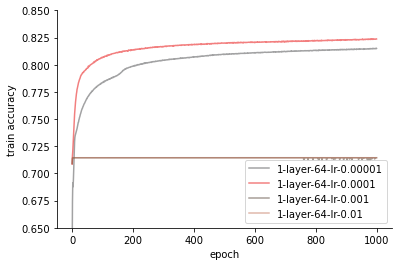

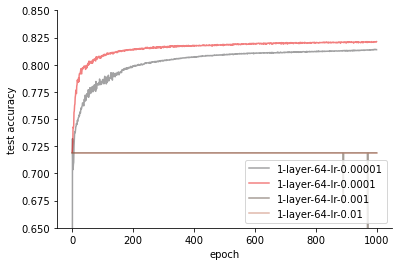

In [101]:
plot_accuracies(hist0, colors=['#464749','#e60000' ,'#4d3c2f', '#c07156', '#806b59', '#b9b2a3'] , alpha=.5, lower_ylim=.65, upper_ylim=.85)

## Learnings
While the accuracy is very similar for all learning rates, the learning rate of 0.001 resulted in the lowest train & validation loss, while also having a slightly higher accuracy than the other leaning rates.

Following we plot the accuracy, loss and the confusion matrix for the learningn rate 0.001

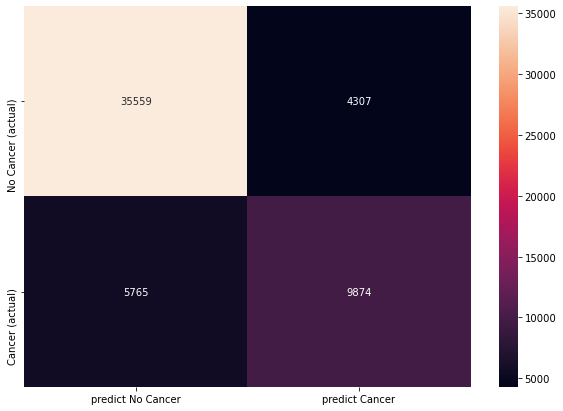

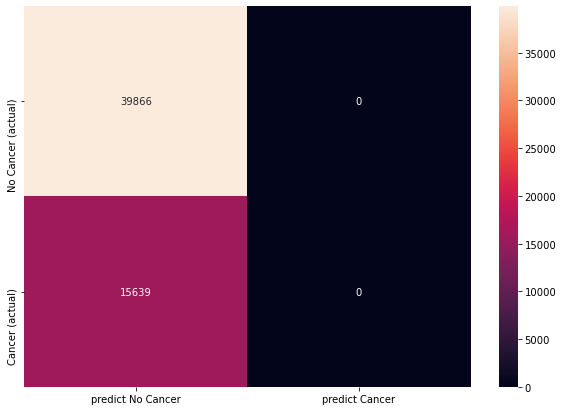

In [63]:
# plot confuction matrix
plt=conf_matrix(model2, x_test, y_test)
plt.show()

# plot confuction matrix
plt=conf_matrix(model3, x_test, y_test)
plt.show()

## Try more hidden nodes and adam optimizer

In [65]:
# lower the number of epochs
epochs = 150

histories = []

name="1-layer-128"
print(name)
model01 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model01.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model01.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-256"
print(name)
model02 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model02.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model02.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512"
print(name)
model03 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model03.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model03.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-1024"
print(name)
model04 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model04.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model04.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model05 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model05.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model05.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096"
print(name)
model06 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model06.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model06.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1 = histories

1-layer-128
Epoch 1/150
163/163 - 1s - loss: 24.7573 - accuracy: 0.6745 - val_loss: 6.5263 - val_accuracy: 0.7375
Epoch 2/150
163/163 - 1s - loss: 8.7851 - accuracy: 0.7086 - val_loss: 6.8934 - val_accuracy: 0.7658
Epoch 3/150
163/163 - 1s - loss: 8.8751 - accuracy: 0.7080 - val_loss: 12.4146 - val_accuracy: 0.7488
Epoch 4/150
163/163 - 1s - loss: 6.0782 - accuracy: 0.7401 - val_loss: 5.0001 - val_accuracy: 0.7023
Epoch 5/150
163/163 - 1s - loss: 7.8641 - accuracy: 0.7084 - val_loss: 6.4988 - val_accuracy: 0.7694
Epoch 6/150
163/163 - 1s - loss: 6.6658 - accuracy: 0.7350 - val_loss: 4.2465 - val_accuracy: 0.7637
Epoch 7/150
163/163 - 1s - loss: 5.4148 - accuracy: 0.7312 - val_loss: 5.8958 - val_accuracy: 0.7688
Epoch 8/150
163/163 - 1s - loss: 7.5337 - accuracy: 0.7187 - val_loss: 4.1051 - val_accuracy: 0.7647
Epoch 9/150
163/163 - 1s - loss: 8.1802 - accuracy: 0.7121 - val_loss: 5.7300 - val_accuracy: 0.7797
Epoch 10/150
163/163 - 1s - loss: 4.5158 - accuracy: 0.7528 - val_loss: 12.04

Epoch 82/150
163/163 - 1s - loss: 2.6265 - accuracy: 0.7465 - val_loss: 1.5137 - val_accuracy: 0.7612
Epoch 83/150
163/163 - 1s - loss: 3.1599 - accuracy: 0.7324 - val_loss: 1.5439 - val_accuracy: 0.7818
Epoch 84/150
163/163 - 1s - loss: 3.1415 - accuracy: 0.7310 - val_loss: 2.3328 - val_accuracy: 0.7689
Epoch 85/150
163/163 - 1s - loss: 2.5956 - accuracy: 0.7452 - val_loss: 1.5660 - val_accuracy: 0.7745
Epoch 86/150
163/163 - 1s - loss: 2.7677 - accuracy: 0.7405 - val_loss: 2.2092 - val_accuracy: 0.7735
Epoch 87/150
163/163 - 1s - loss: 3.2014 - accuracy: 0.7342 - val_loss: 1.7421 - val_accuracy: 0.7579
Epoch 88/150
163/163 - 1s - loss: 2.4563 - accuracy: 0.7397 - val_loss: 2.4948 - val_accuracy: 0.7827
Epoch 89/150
163/163 - 1s - loss: 3.0263 - accuracy: 0.7382 - val_loss: 1.4845 - val_accuracy: 0.7818
Epoch 90/150
163/163 - 1s - loss: 2.1152 - accuracy: 0.7551 - val_loss: 5.4465 - val_accuracy: 0.7235
Epoch 91/150
163/163 - 1s - loss: 2.9490 - accuracy: 0.7340 - val_loss: 1.4452 - v

Epoch 12/150
163/163 - 1s - loss: 8.1153 - accuracy: 0.7260 - val_loss: 3.9100 - val_accuracy: 0.7859
Epoch 13/150
163/163 - 1s - loss: 9.1049 - accuracy: 0.7038 - val_loss: 5.0331 - val_accuracy: 0.7921
Epoch 14/150
163/163 - 1s - loss: 6.6442 - accuracy: 0.7363 - val_loss: 16.6563 - val_accuracy: 0.7308
Epoch 15/150
163/163 - 1s - loss: 7.4316 - accuracy: 0.7230 - val_loss: 5.3609 - val_accuracy: 0.7102
Epoch 16/150
163/163 - 1s - loss: 5.9307 - accuracy: 0.7394 - val_loss: 3.5092 - val_accuracy: 0.7407
Epoch 17/150
163/163 - 1s - loss: 7.1843 - accuracy: 0.7207 - val_loss: 8.3920 - val_accuracy: 0.7581
Epoch 18/150
163/163 - 1s - loss: 7.3322 - accuracy: 0.7221 - val_loss: 21.7291 - val_accuracy: 0.3164
Epoch 19/150
163/163 - 1s - loss: 6.8780 - accuracy: 0.7241 - val_loss: 3.4533 - val_accuracy: 0.7892
Epoch 20/150
163/163 - 1s - loss: 7.2574 - accuracy: 0.7167 - val_loss: 3.8419 - val_accuracy: 0.7972
Epoch 21/150
163/163 - 1s - loss: 4.6277 - accuracy: 0.7434 - val_loss: 3.8800 -

Epoch 93/150
163/163 - 1s - loss: 1.7242 - accuracy: 0.7549 - val_loss: 1.1342 - val_accuracy: 0.7675
Epoch 94/150
163/163 - 1s - loss: 2.8905 - accuracy: 0.7218 - val_loss: 1.1829 - val_accuracy: 0.7926
Epoch 95/150
163/163 - 1s - loss: 1.9026 - accuracy: 0.7495 - val_loss: 1.1679 - val_accuracy: 0.7911
Epoch 96/150
163/163 - 1s - loss: 2.3504 - accuracy: 0.7373 - val_loss: 2.1275 - val_accuracy: 0.7597
Epoch 97/150
163/163 - 1s - loss: 2.6416 - accuracy: 0.7255 - val_loss: 1.5722 - val_accuracy: 0.7762
Epoch 98/150
163/163 - 1s - loss: 1.3926 - accuracy: 0.7641 - val_loss: 1.1789 - val_accuracy: 0.7818
Epoch 99/150
163/163 - 1s - loss: 1.7550 - accuracy: 0.7442 - val_loss: 1.0289 - val_accuracy: 0.7815
Epoch 100/150
163/163 - 1s - loss: 2.7548 - accuracy: 0.7202 - val_loss: 1.1731 - val_accuracy: 0.7718
Epoch 101/150
163/163 - 1s - loss: 1.9722 - accuracy: 0.7413 - val_loss: 2.3786 - val_accuracy: 0.7761
Epoch 102/150
163/163 - 1s - loss: 1.7630 - accuracy: 0.7496 - val_loss: 3.3200 

Epoch 23/150
163/163 - 1s - loss: 6.3196 - accuracy: 0.7506 - val_loss: 4.3692 - val_accuracy: 0.7860
Epoch 24/150
163/163 - 1s - loss: 9.7467 - accuracy: 0.7049 - val_loss: 17.3572 - val_accuracy: 0.7339
Epoch 25/150
163/163 - 1s - loss: 6.3053 - accuracy: 0.7469 - val_loss: 4.1678 - val_accuracy: 0.7835
Epoch 26/150
163/163 - 1s - loss: 7.3346 - accuracy: 0.7296 - val_loss: 11.0839 - val_accuracy: 0.7402
Epoch 27/150
163/163 - 1s - loss: 7.9280 - accuracy: 0.7246 - val_loss: 4.6594 - val_accuracy: 0.7830
Epoch 28/150
163/163 - 1s - loss: 7.9406 - accuracy: 0.7269 - val_loss: 4.3433 - val_accuracy: 0.7890
Epoch 29/150
163/163 - 1s - loss: 8.3655 - accuracy: 0.7102 - val_loss: 4.3803 - val_accuracy: 0.7963
Epoch 30/150
163/163 - 1s - loss: 8.4050 - accuracy: 0.7106 - val_loss: 17.1144 - val_accuracy: 0.7300
Epoch 31/150
163/163 - 1s - loss: 5.5944 - accuracy: 0.7533 - val_loss: 2.8818 - val_accuracy: 0.7893
Epoch 32/150
163/163 - 1s - loss: 8.5277 - accuracy: 0.7079 - val_loss: 10.5811

Epoch 104/150
163/163 - 1s - loss: 1.2431 - accuracy: 0.7555 - val_loss: 2.9948 - val_accuracy: 0.7396
Epoch 105/150
163/163 - 1s - loss: 1.4171 - accuracy: 0.7503 - val_loss: 2.0149 - val_accuracy: 0.7535
Epoch 106/150
163/163 - 1s - loss: 1.2669 - accuracy: 0.7501 - val_loss: 0.9233 - val_accuracy: 0.7568
Epoch 107/150
163/163 - 1s - loss: 1.6193 - accuracy: 0.7333 - val_loss: 1.2331 - val_accuracy: 0.7916
Epoch 108/150
163/163 - 1s - loss: 1.5540 - accuracy: 0.7462 - val_loss: 0.8754 - val_accuracy: 0.7925
Epoch 109/150
163/163 - 1s - loss: 1.7021 - accuracy: 0.7299 - val_loss: 3.3639 - val_accuracy: 0.4281
Epoch 110/150
163/163 - 1s - loss: 1.3423 - accuracy: 0.7513 - val_loss: 0.7999 - val_accuracy: 0.7646
Epoch 111/150
163/163 - 1s - loss: 1.1834 - accuracy: 0.7539 - val_loss: 0.9471 - val_accuracy: 0.7790
Epoch 112/150
163/163 - 1s - loss: 0.9313 - accuracy: 0.7615 - val_loss: 1.0886 - val_accuracy: 0.7739
Epoch 113/150
163/163 - 1s - loss: 1.2353 - accuracy: 0.7487 - val_loss: 

Epoch 34/150
163/163 - 2s - loss: 6.8009 - accuracy: 0.7121 - val_loss: 11.4990 - val_accuracy: 0.7432
Epoch 35/150
163/163 - 2s - loss: 6.8766 - accuracy: 0.7183 - val_loss: 16.1561 - val_accuracy: 0.7266
Epoch 36/150
163/163 - 2s - loss: 7.3193 - accuracy: 0.7308 - val_loss: 3.3656 - val_accuracy: 0.7981
Epoch 37/150
163/163 - 2s - loss: 5.3784 - accuracy: 0.7260 - val_loss: 7.2600 - val_accuracy: 0.7579
Epoch 38/150
163/163 - 2s - loss: 5.0593 - accuracy: 0.7322 - val_loss: 3.3672 - val_accuracy: 0.7934
Epoch 39/150
163/163 - 2s - loss: 5.0871 - accuracy: 0.7297 - val_loss: 2.6499 - val_accuracy: 0.7663
Epoch 40/150
163/163 - 2s - loss: 5.0807 - accuracy: 0.7215 - val_loss: 5.9011 - val_accuracy: 0.7582
Epoch 41/150
163/163 - 2s - loss: 5.8491 - accuracy: 0.7118 - val_loss: 2.9134 - val_accuracy: 0.7940
Epoch 42/150
163/163 - 1s - loss: 3.5302 - accuracy: 0.7544 - val_loss: 7.5543 - val_accuracy: 0.7368
Epoch 43/150
163/163 - 2s - loss: 5.5496 - accuracy: 0.7079 - val_loss: 2.4829 -

Epoch 115/150
163/163 - 2s - loss: 0.8555 - accuracy: 0.7603 - val_loss: 0.5449 - val_accuracy: 0.7952
Epoch 116/150
163/163 - 2s - loss: 0.7127 - accuracy: 0.7679 - val_loss: 0.6001 - val_accuracy: 0.7585
Epoch 117/150
163/163 - 2s - loss: 0.9347 - accuracy: 0.7539 - val_loss: 0.6751 - val_accuracy: 0.8013
Epoch 118/150
163/163 - 2s - loss: 0.7659 - accuracy: 0.7686 - val_loss: 1.3404 - val_accuracy: 0.5350
Epoch 119/150
163/163 - 2s - loss: 0.8141 - accuracy: 0.7631 - val_loss: 0.5603 - val_accuracy: 0.7818
Epoch 120/150
163/163 - 2s - loss: 0.6820 - accuracy: 0.7721 - val_loss: 0.9040 - val_accuracy: 0.7865
Epoch 121/150
163/163 - 2s - loss: 0.7773 - accuracy: 0.7680 - val_loss: 0.5443 - val_accuracy: 0.7985
Epoch 122/150
163/163 - 2s - loss: 0.5612 - accuracy: 0.7833 - val_loss: 0.5206 - val_accuracy: 0.7967
Epoch 123/150
163/163 - 2s - loss: 0.7150 - accuracy: 0.7637 - val_loss: 0.5463 - val_accuracy: 0.7737
Epoch 124/150
163/163 - 2s - loss: 0.5509 - accuracy: 0.7847 - val_loss: 

Epoch 45/150
163/163 - 2s - loss: 3.8218 - accuracy: 0.7319 - val_loss: 2.4133 - val_accuracy: 0.7927
Epoch 46/150
163/163 - 2s - loss: 3.5736 - accuracy: 0.7306 - val_loss: 2.3471 - val_accuracy: 0.7920
Epoch 47/150
163/163 - 3s - loss: 3.5846 - accuracy: 0.7257 - val_loss: 5.5730 - val_accuracy: 0.4506
Epoch 48/150
163/163 - 3s - loss: 3.0994 - accuracy: 0.7366 - val_loss: 1.5327 - val_accuracy: 0.7979
Epoch 49/150
163/163 - 2s - loss: 3.3234 - accuracy: 0.7196 - val_loss: 1.9350 - val_accuracy: 0.7998
Epoch 50/150
163/163 - 3s - loss: 3.0070 - accuracy: 0.7377 - val_loss: 1.9625 - val_accuracy: 0.7597
Epoch 51/150
163/163 - 2s - loss: 2.9251 - accuracy: 0.7341 - val_loss: 1.6260 - val_accuracy: 0.7917
Epoch 52/150
163/163 - 2s - loss: 3.1626 - accuracy: 0.7245 - val_loss: 1.6290 - val_accuracy: 0.7989
Epoch 53/150
163/163 - 2s - loss: 2.5775 - accuracy: 0.7402 - val_loss: 1.7561 - val_accuracy: 0.7877
Epoch 54/150
163/163 - 2s - loss: 2.6533 - accuracy: 0.7312 - val_loss: 1.2804 - v

163/163 - 2s - loss: 0.4553 - accuracy: 0.8018 - val_loss: 0.4322 - val_accuracy: 0.8084
Epoch 126/150
163/163 - 2s - loss: 0.4305 - accuracy: 0.8123 - val_loss: 0.4149 - val_accuracy: 0.8158
Epoch 127/150
163/163 - 2s - loss: 0.4164 - accuracy: 0.8155 - val_loss: 0.4125 - val_accuracy: 0.8172
Epoch 128/150
163/163 - 2s - loss: 0.4093 - accuracy: 0.8185 - val_loss: 0.4075 - val_accuracy: 0.8210
Epoch 129/150
163/163 - 2s - loss: 0.4059 - accuracy: 0.8210 - val_loss: 0.4071 - val_accuracy: 0.8214
Epoch 130/150
163/163 - 2s - loss: 0.4060 - accuracy: 0.8212 - val_loss: 0.4093 - val_accuracy: 0.8207
Epoch 131/150
163/163 - 2s - loss: 0.4040 - accuracy: 0.8219 - val_loss: 0.4055 - val_accuracy: 0.8210
Epoch 132/150
163/163 - 2s - loss: 0.4067 - accuracy: 0.8212 - val_loss: 0.4072 - val_accuracy: 0.8205
Epoch 133/150
163/163 - 2s - loss: 0.4437 - accuracy: 0.8076 - val_loss: 0.4204 - val_accuracy: 0.8153
Epoch 134/150
163/163 - 2s - loss: 0.4067 - accuracy: 0.8210 - val_loss: 0.4054 - val_a

Epoch 55/150
163/163 - 4s - loss: 1.8782 - accuracy: 0.7221 - val_loss: 1.0854 - val_accuracy: 0.8015
Epoch 56/150
163/163 - 4s - loss: 1.3928 - accuracy: 0.7536 - val_loss: 0.7864 - val_accuracy: 0.7856
Epoch 57/150
163/163 - 4s - loss: 1.5873 - accuracy: 0.7280 - val_loss: 0.8694 - val_accuracy: 0.8023
Epoch 58/150
163/163 - 4s - loss: 0.9571 - accuracy: 0.7744 - val_loss: 0.6698 - val_accuracy: 0.7843
Epoch 59/150
163/163 - 4s - loss: 1.4645 - accuracy: 0.7191 - val_loss: 2.6929 - val_accuracy: 0.7346
Epoch 60/150
163/163 - 4s - loss: 1.3228 - accuracy: 0.7351 - val_loss: 1.9024 - val_accuracy: 0.7541
Epoch 61/150
163/163 - 4s - loss: 0.9384 - accuracy: 0.7627 - val_loss: 1.4465 - val_accuracy: 0.7546
Epoch 62/150
163/163 - 4s - loss: 0.9441 - accuracy: 0.7480 - val_loss: 1.0892 - val_accuracy: 0.7697
Epoch 63/150
163/163 - 4s - loss: 1.2109 - accuracy: 0.7341 - val_loss: 0.9099 - val_accuracy: 0.7738
Epoch 64/150
163/163 - 4s - loss: 0.9832 - accuracy: 0.7452 - val_loss: 1.3907 - v

Epoch 135/150
163/163 - 4s - loss: 0.4035 - accuracy: 0.8208 - val_loss: 0.4075 - val_accuracy: 0.8192
Epoch 136/150
163/163 - 4s - loss: 0.4013 - accuracy: 0.8226 - val_loss: 0.4071 - val_accuracy: 0.8208
Epoch 137/150
163/163 - 4s - loss: 0.4090 - accuracy: 0.8189 - val_loss: 0.4087 - val_accuracy: 0.8178
Epoch 138/150
163/163 - 4s - loss: 0.4038 - accuracy: 0.8216 - val_loss: 0.4088 - val_accuracy: 0.8191
Epoch 139/150
163/163 - 4s - loss: 0.4025 - accuracy: 0.8226 - val_loss: 0.4135 - val_accuracy: 0.8169
Epoch 140/150
163/163 - 4s - loss: 0.3997 - accuracy: 0.8239 - val_loss: 0.4015 - val_accuracy: 0.8246
Epoch 141/150
163/163 - 4s - loss: 0.3987 - accuracy: 0.8245 - val_loss: 0.4003 - val_accuracy: 0.8246
Epoch 142/150
163/163 - 4s - loss: 0.3987 - accuracy: 0.8248 - val_loss: 0.4037 - val_accuracy: 0.8208
Epoch 143/150
163/163 - 4s - loss: 0.3990 - accuracy: 0.8246 - val_loss: 0.4072 - val_accuracy: 0.8190
Epoch 144/150
163/163 - 4s - loss: 0.3986 - accuracy: 0.8245 - val_loss: 

In [74]:
acc_df(hist1)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128,2.45,73.45%,1.43,79.99%
1-layer-256,1.59,72.70%,0.70,79.99%
1-layer-512,5.79,71.18%,2.57,80.10%
1-layer-1024,0.44,80.70%,0.43,80.99%
1-layer-2048,0.41,82.10%,0.41,82.14%
1-layer-4096,0.40,82.39%,0.40,82.46%


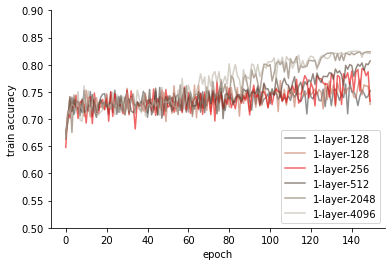

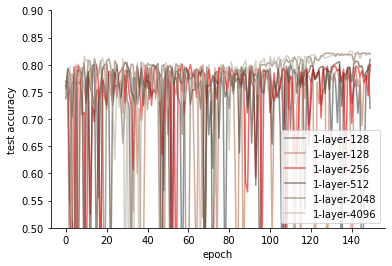

In [108]:
plot_accuracies(hist1, colors=['#464749' , '#c07156' ,'#e60000', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=.9)

In [102]:
# lower the number of epochs
epochs = 150

histories = []

name="1-layer-128"
print(name)
model001 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model001.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model001.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-256"
print(name)
model002 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model002.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model002.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512"
print(name)
model003 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model003.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model003.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-1024"
print(name)
model004 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model004.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model004.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model005 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model005.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model005.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096"
print(name)
model006 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model006.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model06.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1_2 = histories

1-layer-128
Epoch 1/150
163/163 - 1s - loss: 46.2694 - accuracy: 0.6432 - val_loss: 0.6768 - val_accuracy: 0.7190
Epoch 2/150
163/163 - 1s - loss: 0.6654 - accuracy: 0.7144 - val_loss: 0.6532 - val_accuracy: 0.7190
Epoch 3/150
163/163 - 1s - loss: 0.6449 - accuracy: 0.7144 - val_loss: 0.6348 - val_accuracy: 0.7190
Epoch 4/150
163/163 - 1s - loss: 0.6294 - accuracy: 0.7144 - val_loss: 0.6212 - val_accuracy: 0.7190
Epoch 5/150
163/163 - 1s - loss: 0.6183 - accuracy: 0.7144 - val_loss: 0.6115 - val_accuracy: 0.7190
Epoch 6/150
163/163 - 1s - loss: 0.6107 - accuracy: 0.7144 - val_loss: 0.6049 - val_accuracy: 0.7190
Epoch 7/150
163/163 - 1s - loss: 0.6056 - accuracy: 0.7144 - val_loss: 0.6006 - val_accuracy: 0.7190
Epoch 8/150
163/163 - 1s - loss: 0.6024 - accuracy: 0.7144 - val_loss: 0.5978 - val_accuracy: 0.7190
Epoch 9/150
163/163 - 1s - loss: 0.6004 - accuracy: 0.7144 - val_loss: 0.5961 - val_accuracy: 0.7190
Epoch 10/150
163/163 - 1s - loss: 0.5993 - accuracy: 0.7144 - val_loss: 0.5952

Epoch 82/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 83/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 84/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 85/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 86/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5939 - val_accuracy: 0.7190
Epoch 87/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 88/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 89/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 90/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 91/150
163/163 - 1s - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - v

Epoch 12/150
163/163 - 1s - loss: 13.0338 - accuracy: 0.7538 - val_loss: 33.7679 - val_accuracy: 0.7216
Epoch 13/150
163/163 - 1s - loss: 16.8215 - accuracy: 0.7132 - val_loss: 5.8929 - val_accuracy: 0.8082
Epoch 14/150
163/163 - 1s - loss: 13.0077 - accuracy: 0.7420 - val_loss: 5.4989 - val_accuracy: 0.8015
Epoch 15/150
163/163 - 1s - loss: 12.7583 - accuracy: 0.7274 - val_loss: 11.5158 - val_accuracy: 0.7539
Epoch 16/150
163/163 - 1s - loss: 23.5327 - accuracy: 0.6758 - val_loss: 21.8712 - val_accuracy: 0.7484
Epoch 17/150
163/163 - 1s - loss: 7.4472 - accuracy: 0.7766 - val_loss: 4.0919 - val_accuracy: 0.8057
Epoch 18/150
163/163 - 1s - loss: 10.3241 - accuracy: 0.7214 - val_loss: 8.1655 - val_accuracy: 0.5911
Epoch 19/150
163/163 - 1s - loss: 10.9772 - accuracy: 0.7115 - val_loss: 4.7418 - val_accuracy: 0.8016
Epoch 20/150
163/163 - 1s - loss: 7.5168 - accuracy: 0.7424 - val_loss: 8.0450 - val_accuracy: 0.7545
Epoch 21/150
163/163 - 1s - loss: 9.1572 - accuracy: 0.7122 - val_loss: 

Epoch 93/150
163/163 - 1s - loss: 0.4077 - accuracy: 0.8177 - val_loss: 0.4061 - val_accuracy: 0.8194
Epoch 94/150
163/163 - 1s - loss: 0.4065 - accuracy: 0.8187 - val_loss: 0.4060 - val_accuracy: 0.8179
Epoch 95/150
163/163 - 1s - loss: 0.4104 - accuracy: 0.8180 - val_loss: 0.4076 - val_accuracy: 0.8177
Epoch 96/150
163/163 - 1s - loss: 0.4073 - accuracy: 0.8185 - val_loss: 0.4137 - val_accuracy: 0.8147
Epoch 97/150
163/163 - 1s - loss: 0.4057 - accuracy: 0.8191 - val_loss: 0.4047 - val_accuracy: 0.8196
Epoch 98/150
163/163 - 1s - loss: 0.4080 - accuracy: 0.8187 - val_loss: 0.4252 - val_accuracy: 0.8143
Epoch 99/150
163/163 - 1s - loss: 0.4129 - accuracy: 0.8168 - val_loss: 0.4050 - val_accuracy: 0.8195
Epoch 100/150
163/163 - 1s - loss: 0.4083 - accuracy: 0.8178 - val_loss: 0.4092 - val_accuracy: 0.8183
Epoch 101/150
163/163 - 1s - loss: 0.4071 - accuracy: 0.8194 - val_loss: 0.4048 - val_accuracy: 0.8190
Epoch 102/150
163/163 - 1s - loss: 0.4061 - accuracy: 0.8193 - val_loss: 0.4091 

Epoch 23/150
163/163 - 1s - loss: 0.6119 - accuracy: 0.7703 - val_loss: 0.7946 - val_accuracy: 0.6506
Epoch 24/150
163/163 - 1s - loss: 1.0878 - accuracy: 0.7272 - val_loss: 0.5073 - val_accuracy: 0.7970
Epoch 25/150
163/163 - 1s - loss: 0.4871 - accuracy: 0.7959 - val_loss: 0.4908 - val_accuracy: 0.7883
Epoch 26/150
163/163 - 1s - loss: 0.5059 - accuracy: 0.7844 - val_loss: 0.4707 - val_accuracy: 0.7959
Epoch 27/150
163/163 - 1s - loss: 0.4791 - accuracy: 0.7916 - val_loss: 0.5713 - val_accuracy: 0.7413
Epoch 28/150
163/163 - 1s - loss: 0.5119 - accuracy: 0.7836 - val_loss: 0.5406 - val_accuracy: 0.7900
Epoch 29/150
163/163 - 1s - loss: 0.4914 - accuracy: 0.7893 - val_loss: 0.4341 - val_accuracy: 0.8083
Epoch 30/150
163/163 - 1s - loss: 0.4939 - accuracy: 0.7874 - val_loss: 0.4944 - val_accuracy: 0.7902
Epoch 31/150
163/163 - 1s - loss: 0.4691 - accuracy: 0.7943 - val_loss: 0.4249 - val_accuracy: 0.8129
Epoch 32/150
163/163 - 1s - loss: 0.4530 - accuracy: 0.8002 - val_loss: 0.4349 - v

Epoch 104/150
163/163 - 1s - loss: 0.4030 - accuracy: 0.8227 - val_loss: 0.3997 - val_accuracy: 0.8243
Epoch 105/150
163/163 - 1s - loss: 0.4010 - accuracy: 0.8242 - val_loss: 0.4006 - val_accuracy: 0.8241
Epoch 106/150
163/163 - 1s - loss: 0.4009 - accuracy: 0.8245 - val_loss: 0.4066 - val_accuracy: 0.8220
Epoch 107/150
163/163 - 1s - loss: 0.4000 - accuracy: 0.8241 - val_loss: 0.4360 - val_accuracy: 0.8177
Epoch 108/150
163/163 - 1s - loss: 0.4053 - accuracy: 0.8233 - val_loss: 0.4464 - val_accuracy: 0.8017
Epoch 109/150
163/163 - 1s - loss: 0.4062 - accuracy: 0.8234 - val_loss: 0.4009 - val_accuracy: 0.8214
Epoch 110/150
163/163 - 1s - loss: 0.4008 - accuracy: 0.8241 - val_loss: 0.4412 - val_accuracy: 0.8082
Epoch 111/150
163/163 - 1s - loss: 0.4256 - accuracy: 0.8172 - val_loss: 0.4299 - val_accuracy: 0.8060
Epoch 112/150
163/163 - 1s - loss: 0.4151 - accuracy: 0.8190 - val_loss: 0.4019 - val_accuracy: 0.8218
Epoch 113/150
163/163 - 1s - loss: 0.3985 - accuracy: 0.8250 - val_loss: 

Epoch 34/150
163/163 - 2s - loss: 0.4277 - accuracy: 0.8105 - val_loss: 0.4184 - val_accuracy: 0.8134
Epoch 35/150
163/163 - 2s - loss: 0.4191 - accuracy: 0.8145 - val_loss: 0.4275 - val_accuracy: 0.8090
Epoch 36/150
163/163 - 2s - loss: 0.4149 - accuracy: 0.8160 - val_loss: 0.4178 - val_accuracy: 0.8150
Epoch 37/150
163/163 - 2s - loss: 0.4328 - accuracy: 0.8088 - val_loss: 0.4195 - val_accuracy: 0.8146
Epoch 38/150
163/163 - 2s - loss: 0.4163 - accuracy: 0.8155 - val_loss: 0.4287 - val_accuracy: 0.8087
Epoch 39/150
163/163 - 2s - loss: 0.4166 - accuracy: 0.8165 - val_loss: 0.4722 - val_accuracy: 0.8022
Epoch 40/150
163/163 - 2s - loss: 0.4465 - accuracy: 0.8049 - val_loss: 0.4283 - val_accuracy: 0.8105
Epoch 41/150
163/163 - 2s - loss: 0.4073 - accuracy: 0.8207 - val_loss: 0.4094 - val_accuracy: 0.8202
Epoch 42/150
163/163 - 2s - loss: 0.4065 - accuracy: 0.8213 - val_loss: 0.4137 - val_accuracy: 0.8182
Epoch 43/150
163/163 - 2s - loss: 0.4102 - accuracy: 0.8201 - val_loss: 0.4351 - v

Epoch 115/150
163/163 - 2s - loss: 0.4036 - accuracy: 0.8218 - val_loss: 0.4038 - val_accuracy: 0.8213
Epoch 116/150
163/163 - 2s - loss: 0.4087 - accuracy: 0.8200 - val_loss: 0.4202 - val_accuracy: 0.8163
Epoch 117/150
163/163 - 2s - loss: 0.4012 - accuracy: 0.8233 - val_loss: 0.4052 - val_accuracy: 0.8209
Epoch 118/150
163/163 - 2s - loss: 0.4014 - accuracy: 0.8228 - val_loss: 0.4089 - val_accuracy: 0.8191
Epoch 119/150
163/163 - 2s - loss: 0.4177 - accuracy: 0.8206 - val_loss: 0.4114 - val_accuracy: 0.8182
Epoch 120/150
163/163 - 2s - loss: 0.4020 - accuracy: 0.8226 - val_loss: 0.4209 - val_accuracy: 0.8168
Epoch 121/150
163/163 - 2s - loss: 0.4010 - accuracy: 0.8230 - val_loss: 0.4167 - val_accuracy: 0.8189
Epoch 122/150
163/163 - 2s - loss: 0.4004 - accuracy: 0.8232 - val_loss: 0.4015 - val_accuracy: 0.8219
Epoch 123/150
163/163 - 2s - loss: 0.4086 - accuracy: 0.8208 - val_loss: 0.4050 - val_accuracy: 0.8207
Epoch 124/150
163/163 - 2s - loss: 0.4008 - accuracy: 0.8233 - val_loss: 

Epoch 45/150
163/163 - 2s - loss: 0.4078 - accuracy: 0.8228 - val_loss: 0.3961 - val_accuracy: 0.8258
Epoch 46/150
163/163 - 2s - loss: 0.4063 - accuracy: 0.8230 - val_loss: 0.4037 - val_accuracy: 0.8212
Epoch 47/150
163/163 - 2s - loss: 0.4078 - accuracy: 0.8219 - val_loss: 0.4117 - val_accuracy: 0.8173
Epoch 48/150
163/163 - 2s - loss: 0.5275 - accuracy: 0.8042 - val_loss: 0.4363 - val_accuracy: 0.8045
Epoch 49/150
163/163 - 2s - loss: 0.4339 - accuracy: 0.8140 - val_loss: 0.4391 - val_accuracy: 0.8192
Epoch 50/150
163/163 - 2s - loss: 0.4248 - accuracy: 0.8151 - val_loss: 0.4126 - val_accuracy: 0.8197
Epoch 51/150
163/163 - 2s - loss: 0.4221 - accuracy: 0.8165 - val_loss: 0.4160 - val_accuracy: 0.8217
Epoch 52/150
163/163 - 2s - loss: 0.4140 - accuracy: 0.8196 - val_loss: 0.4799 - val_accuracy: 0.7932
Epoch 53/150
163/163 - 2s - loss: 0.4176 - accuracy: 0.8181 - val_loss: 0.4153 - val_accuracy: 0.8162
Epoch 54/150
163/163 - 2s - loss: 0.4134 - accuracy: 0.8184 - val_loss: 0.4227 - v

163/163 - 2s - loss: 0.4164 - accuracy: 0.8120 - val_loss: 0.4220 - val_accuracy: 0.8106
Epoch 126/150
163/163 - 2s - loss: 0.4174 - accuracy: 0.8114 - val_loss: 0.4174 - val_accuracy: 0.8103
Epoch 127/150
163/163 - 2s - loss: 0.4158 - accuracy: 0.8115 - val_loss: 0.4197 - val_accuracy: 0.8095
Epoch 128/150
163/163 - 2s - loss: 0.4215 - accuracy: 0.8101 - val_loss: 0.4360 - val_accuracy: 0.8053
Epoch 129/150
163/163 - 2s - loss: 0.4188 - accuracy: 0.8112 - val_loss: 0.4236 - val_accuracy: 0.8095
Epoch 130/150
163/163 - 2s - loss: 0.4172 - accuracy: 0.8112 - val_loss: 0.4359 - val_accuracy: 0.8070
Epoch 131/150
163/163 - 2s - loss: 0.4191 - accuracy: 0.8109 - val_loss: 0.4450 - val_accuracy: 0.8036
Epoch 132/150
163/163 - 2s - loss: 0.4206 - accuracy: 0.8104 - val_loss: 0.4271 - val_accuracy: 0.8098
Epoch 133/150
163/163 - 2s - loss: 0.4169 - accuracy: 0.8120 - val_loss: 0.4177 - val_accuracy: 0.8104
Epoch 134/150
163/163 - 2s - loss: 0.4166 - accuracy: 0.8115 - val_loss: 0.4203 - val_a

Epoch 56/150
163/163 - 4s - loss: 0.3955 - accuracy: 0.8258 - val_loss: 0.4031 - val_accuracy: 0.8222
Epoch 57/150
163/163 - 4s - loss: 0.3885 - accuracy: 0.8292 - val_loss: 0.4055 - val_accuracy: 0.8205
Epoch 58/150
163/163 - 4s - loss: 0.3899 - accuracy: 0.8283 - val_loss: 0.4017 - val_accuracy: 0.8241
Epoch 59/150
163/163 - 4s - loss: 0.3992 - accuracy: 0.8247 - val_loss: 0.4067 - val_accuracy: 0.8219
Epoch 60/150
163/163 - 4s - loss: 0.3881 - accuracy: 0.8294 - val_loss: 0.4081 - val_accuracy: 0.8201
Epoch 61/150
163/163 - 4s - loss: 0.3872 - accuracy: 0.8297 - val_loss: 0.4030 - val_accuracy: 0.8240
Epoch 62/150
163/163 - 4s - loss: 0.3877 - accuracy: 0.8298 - val_loss: 0.4038 - val_accuracy: 0.8217
Epoch 63/150
163/163 - 4s - loss: 0.3883 - accuracy: 0.8291 - val_loss: 0.4067 - val_accuracy: 0.8208
Epoch 64/150
163/163 - 4s - loss: 0.3873 - accuracy: 0.8302 - val_loss: 0.4044 - val_accuracy: 0.8221
Epoch 65/150
163/163 - 4s - loss: 0.3887 - accuracy: 0.8292 - val_loss: 0.4011 - v

Epoch 136/150
163/163 - 4s - loss: 0.3768 - accuracy: 0.8349 - val_loss: 0.4190 - val_accuracy: 0.8148
Epoch 137/150
163/163 - 4s - loss: 0.3764 - accuracy: 0.8351 - val_loss: 0.4053 - val_accuracy: 0.8224
Epoch 138/150
163/163 - 4s - loss: 0.3781 - accuracy: 0.8343 - val_loss: 0.4044 - val_accuracy: 0.8223
Epoch 139/150
163/163 - 4s - loss: 0.3764 - accuracy: 0.8356 - val_loss: 0.4054 - val_accuracy: 0.8221
Epoch 140/150
163/163 - 4s - loss: 0.3770 - accuracy: 0.8349 - val_loss: 0.4043 - val_accuracy: 0.8229
Epoch 141/150
163/163 - 4s - loss: 0.3771 - accuracy: 0.8352 - val_loss: 0.4098 - val_accuracy: 0.8194
Epoch 142/150
163/163 - 4s - loss: 0.3774 - accuracy: 0.8354 - val_loss: 0.4056 - val_accuracy: 0.8207
Epoch 143/150
163/163 - 4s - loss: 0.3762 - accuracy: 0.8352 - val_loss: 0.4069 - val_accuracy: 0.8203
Epoch 144/150
163/163 - 4s - loss: 0.3773 - accuracy: 0.8349 - val_loss: 0.4182 - val_accuracy: 0.8161
Epoch 145/150
163/163 - 4s - loss: 0.3758 - accuracy: 0.8354 - val_loss: 

In [14]:
acc_df(hist1_2)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64,0.40,82.47%,0.40,82.69%
1-layer-128,0.40,82.25%,0.41,82.06%
1-layer-256,0.41,82.43%,0.40,82.83%
1-layer-512,0.40,82.19%,0.40,82.55%
1-layer-2048,0.41,82.14%,0.39,82.67%
1-layer-4096,0.40,82.29%,0.40,81.98%


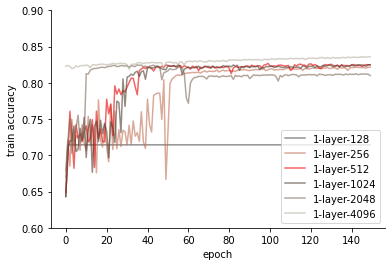

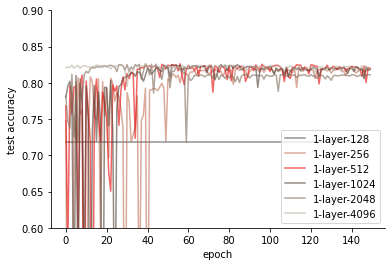

In [107]:
plot_accuracies(hist1_2, colors=['#464749' , '#c07156', '#e60000', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.6, upper_ylim=.9)

## Results from simple dense net

The simple dense net reaches a accuracy on out test dataset of nearly 72 percent. This sounds respectable for such a simple network. A closer look on our confusion matrix reveals that our network suffers from our imbalanced data and is not able to counter the imbalance and thus classifies nearly all patches as non-cancer.


At this point it is difficult to assess what exactly has to be improved, but we suspect the following issues persist:

1. The Neural Network does not learn enough from the features, most likely the size of the network is insufficient to learn the features. When increasing the number of layers and the size of the layers we will encounter additional challenges:
    - We could be overfitting our data, which we can mitigate by using dropbout layer
    - We could have a vanishing gradient, which can be mitigated by using normalisazion betweek the hidden layers 
2. The network minimizes the loss, since the data is imbalanced it will inherently favor negative classifications. To counter this multiple options are available
    - We could downsample the negative patches or upsample the positive patches , where the latter is preferred since no data is ignored this way.
    - We could apply balanced weights to increase the impact to the loss function for the positive patches. This should result in an equivalent result than the upsampling.

We will takle the two above mentioned issues after each other. Fist we try to increase the model size and tune the hyperparameters to fit the data better and learn the complexity of the input. Second we will apply class weights to tackle specifically the imbalanced data

In [103]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model07 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model07.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model07.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="1-layer-4096-norm-dropout"
print(name)
model08 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model08.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model08.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))


name="2-layer-128-256"
print(name)
model09 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model09.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model09.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-256-512-256"
print(name)
model10 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model10.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model10.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-norm"
print(name)
model11 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model11.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model11.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-dropout"
print(name)
model12 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model12.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model12.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-norm-dropout"
print(name)
model13 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model13.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model13.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))
hist2 = histories

1-layer-128-norm-dropout
Epoch 1/500
163/163 - 1s - loss: 0.8033 - accuracy: 0.7783 - val_loss: 1.1868 - val_accuracy: 0.7621
Epoch 2/500
163/163 - 1s - loss: 0.4051 - accuracy: 0.8283 - val_loss: 0.4588 - val_accuracy: 0.8093
Epoch 3/500
163/163 - 1s - loss: 0.3798 - accuracy: 0.8410 - val_loss: 0.3730 - val_accuracy: 0.8443
Epoch 4/500
163/163 - 1s - loss: 0.3634 - accuracy: 0.8490 - val_loss: 0.3655 - val_accuracy: 0.8477
Epoch 5/500
163/163 - 1s - loss: 0.3544 - accuracy: 0.8530 - val_loss: 0.3591 - val_accuracy: 0.8502
Epoch 6/500
163/163 - 1s - loss: 0.3474 - accuracy: 0.8564 - val_loss: 0.3578 - val_accuracy: 0.8502
Epoch 7/500
163/163 - 1s - loss: 0.3402 - accuracy: 0.8600 - val_loss: 0.3596 - val_accuracy: 0.8513
Epoch 8/500
163/163 - 1s - loss: 0.3364 - accuracy: 0.8612 - val_loss: 0.3589 - val_accuracy: 0.8511
Epoch 9/500
163/163 - 1s - loss: 0.3301 - accuracy: 0.8632 - val_loss: 0.3593 - val_accuracy: 0.8502
Epoch 10/500
163/163 - 1s - loss: 0.3274 - accuracy: 0.8653 - val_

Epoch 3/500
163/163 - 1s - loss: 0.4629 - accuracy: 0.7905 - val_loss: 0.4361 - val_accuracy: 0.8055
Epoch 4/500
163/163 - 1s - loss: 0.4604 - accuracy: 0.7920 - val_loss: 0.5686 - val_accuracy: 0.7321
Epoch 5/500
163/163 - 1s - loss: 0.4505 - accuracy: 0.7969 - val_loss: 0.4933 - val_accuracy: 0.7725
Epoch 6/500
163/163 - 1s - loss: 0.4519 - accuracy: 0.7959 - val_loss: 0.4289 - val_accuracy: 0.8103
Epoch 7/500
163/163 - 1s - loss: 0.4316 - accuracy: 0.8056 - val_loss: 0.4315 - val_accuracy: 0.8065
Epoch 8/500
163/163 - 1s - loss: 0.4378 - accuracy: 0.8034 - val_loss: 0.4419 - val_accuracy: 0.8025
Epoch 9/500
163/163 - 1s - loss: 0.4344 - accuracy: 0.8049 - val_loss: 0.4400 - val_accuracy: 0.8035
Epoch 10/500
163/163 - 1s - loss: 0.4300 - accuracy: 0.8082 - val_loss: 0.4163 - val_accuracy: 0.8152
Epoch 11/500
163/163 - 1s - loss: 0.4326 - accuracy: 0.8064 - val_loss: 0.4147 - val_accuracy: 0.8149
Epoch 12/500
163/163 - 1s - loss: 0.4692 - accuracy: 0.7900 - val_loss: 0.4770 - val_accu

Epoch 00042: early stopping
3-layer-512-256-128-norm
Epoch 1/500
163/163 - 1s - loss: 0.3829 - accuracy: 0.8332 - val_loss: 1.1639 - val_accuracy: 0.7189
Epoch 2/500
163/163 - 1s - loss: 0.3462 - accuracy: 0.8510 - val_loss: 0.6702 - val_accuracy: 0.7245
Epoch 3/500
163/163 - 1s - loss: 0.3349 - accuracy: 0.8574 - val_loss: 1.2658 - val_accuracy: 0.7233
Epoch 4/500
163/163 - 1s - loss: 0.3247 - accuracy: 0.8618 - val_loss: 0.9890 - val_accuracy: 0.7212
Epoch 5/500
163/163 - 1s - loss: 0.3164 - accuracy: 0.8667 - val_loss: 0.7416 - val_accuracy: 0.7277
Epoch 6/500
163/163 - 1s - loss: 0.3067 - accuracy: 0.8706 - val_loss: 0.6543 - val_accuracy: 0.7431
Epoch 7/500
163/163 - 1s - loss: 0.2978 - accuracy: 0.8759 - val_loss: 1.8089 - val_accuracy: 0.7190
Epoch 8/500
163/163 - 1s - loss: 0.2890 - accuracy: 0.8796 - val_loss: 0.9468 - val_accuracy: 0.7224
Epoch 9/500
163/163 - 1s - loss: 0.2787 - accuracy: 0.8853 - val_loss: 0.4475 - val_accuracy: 0.8046
Epoch 10/500
163/163 - 1s - loss: 0.27

Epoch 7/500
163/163 - 1s - loss: 0.3516 - accuracy: 0.8511 - val_loss: 0.4684 - val_accuracy: 0.7754
Epoch 8/500
163/163 - 1s - loss: 0.3482 - accuracy: 0.8525 - val_loss: 0.4273 - val_accuracy: 0.7952
Epoch 9/500
163/163 - 1s - loss: 0.3441 - accuracy: 0.8553 - val_loss: 0.4586 - val_accuracy: 0.7903
Epoch 10/500
163/163 - 1s - loss: 0.3418 - accuracy: 0.8565 - val_loss: 0.7166 - val_accuracy: 0.7186
Epoch 11/500
163/163 - 1s - loss: 0.3397 - accuracy: 0.8577 - val_loss: 0.4251 - val_accuracy: 0.7686
Epoch 12/500
163/163 - 1s - loss: 0.3363 - accuracy: 0.8597 - val_loss: 0.4861 - val_accuracy: 0.7894
Epoch 13/500
163/163 - 1s - loss: 0.3340 - accuracy: 0.8610 - val_loss: 0.4587 - val_accuracy: 0.8067
Epoch 14/500
163/163 - 1s - loss: 0.3299 - accuracy: 0.8628 - val_loss: 0.7554 - val_accuracy: 0.7519
Epoch 15/500
163/163 - 1s - loss: 0.3283 - accuracy: 0.8632 - val_loss: 0.7908 - val_accuracy: 0.7265
Epoch 16/500
163/163 - 1s - loss: 0.3267 - accuracy: 0.8646 - val_loss: 0.4728 - val_

In [17]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.32,87.07%,0.36,85.29%
1-layer-4096-norm-dropout,0.27,89.58%,0.39,85.40%
2-layer-128-256,0.42,81.29%,0.42,81.51%
3-layer-256-512-256,0.41,81.85%,0.40,82.39%
3-layer-512-256-128-norm,0.33,85.64%,0.49,79.20%
3-layer-512-256-128-dropout,0.35,85.12%,0.43,83.03%
3-layer-512-256-128-norm-dropout,0.37,84.18%,0.50,82.94%


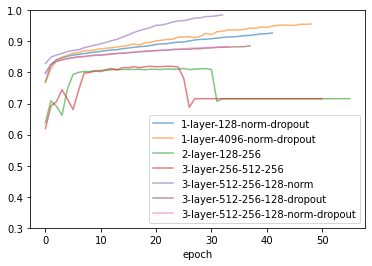

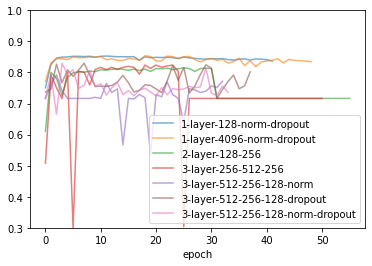

In [33]:
plot_accuracies(hist2, lower_ylim=.3, upper_ylim=1)

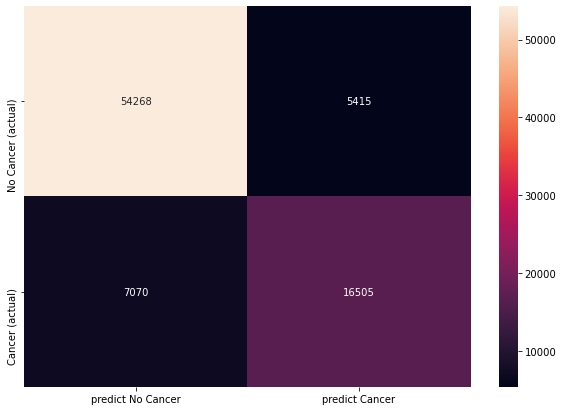

In [19]:
# plot confuction matrix
plt=conf_matrix(model08, x_test, y_test)
plt.show()

## Learnings
- In the above chart we first of all see that just increasing the number of layers and the number of hidden nodes per layer did not improve the performance. On the contrary we can recognize that in the 3rd network the loss is increasing significantly and and the fourth and fifth layer the loss cannot be displayed. This evidence suggests an exploding/vanishing gradient.
- None of the models are able to reach higher performance for our imbalanced dataset and account for the cancer positive cells
With the different model sizes, learning rates, normalization and dropout layers most issues should have be tackled, so lets run tha above models again with balanced weights, that account for the relative number of positive/negative patches

In [20]:
# lower the number of epochs
epochs = 150

total = numpy.asarray(y_data).shape[0]
pos = sum(numpy.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.40
Weight for class 1: 3.52


In [21]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model14 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model14.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model14.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))


name="2-layer-128-256-norm-dropout"
print(name)
model15 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model15.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model15.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model16 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model16.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model16.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))
hist3 = histories

1-layer-128-norm-dropout
Epoch 1/500
152/152 - 1s - loss: 4.1757 - accuracy: 0.7607 - val_loss: 1.5602 - val_accuracy: 0.7648
Epoch 2/500
152/152 - 1s - loss: 0.9047 - accuracy: 0.7916 - val_loss: 0.4273 - val_accuracy: 0.8326
Epoch 3/500
152/152 - 1s - loss: 0.8776 - accuracy: 0.7977 - val_loss: 0.4223 - val_accuracy: 0.8063
Epoch 4/500
152/152 - 1s - loss: 0.8598 - accuracy: 0.8022 - val_loss: 0.4096 - val_accuracy: 0.8092
Epoch 5/500
152/152 - 1s - loss: 0.8444 - accuracy: 0.8064 - val_loss: 0.3826 - val_accuracy: 0.8307
Epoch 6/500
152/152 - 1s - loss: 0.8379 - accuracy: 0.8047 - val_loss: 0.3853 - val_accuracy: 0.8267
Epoch 7/500
152/152 - 1s - loss: 0.8293 - accuracy: 0.8066 - val_loss: 0.4253 - val_accuracy: 0.7978
Epoch 8/500
152/152 - 1s - loss: 0.8213 - accuracy: 0.8088 - val_loss: 0.4338 - val_accuracy: 0.7971
Epoch 9/500
152/152 - 1s - loss: 0.8097 - accuracy: 0.8116 - val_loss: 0.4199 - val_accuracy: 0.8015
Epoch 10/500
152/152 - 1s - loss: 0.8110 - accuracy: 0.8104 - val_

Epoch 14/500
152/152 - 1s - loss: 0.7758 - accuracy: 0.8335 - val_loss: 0.4466 - val_accuracy: 0.8169
Epoch 15/500
152/152 - 1s - loss: 0.7682 - accuracy: 0.8345 - val_loss: 0.6460 - val_accuracy: 0.7879
Epoch 16/500
152/152 - 1s - loss: 0.7627 - accuracy: 0.8363 - val_loss: 0.5061 - val_accuracy: 0.7944
Epoch 17/500
152/152 - 1s - loss: 0.7586 - accuracy: 0.8370 - val_loss: 0.5033 - val_accuracy: 0.8011
Epoch 18/500
152/152 - 1s - loss: 0.7543 - accuracy: 0.8387 - val_loss: 0.4084 - val_accuracy: 0.8250
Epoch 19/500
152/152 - 1s - loss: 0.7492 - accuracy: 0.8399 - val_loss: 0.7604 - val_accuracy: 0.7617
Epoch 20/500
152/152 - 1s - loss: 0.7453 - accuracy: 0.8404 - val_loss: 0.4136 - val_accuracy: 0.8226
Epoch 21/500
152/152 - 1s - loss: 0.7368 - accuracy: 0.8429 - val_loss: 0.4603 - val_accuracy: 0.7977
Epoch 22/500
152/152 - 1s - loss: 0.7390 - accuracy: 0.8420 - val_loss: 1.5672 - val_accuracy: 0.7515
Epoch 23/500
152/152 - 1s - loss: 0.7321 - accuracy: 0.8436 - val_loss: 0.5389 - v

In [22]:
acc_df(hist3)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.90,79.16%,0.43,83.26%
2-layer-128-256-norm-dropout,0.86,81.00%,0.37,84.09%
3-layer-512-256-128-norm-dropout,0.72,84.61%,0.42,83.01%


In [1]:
plot_accuracies(hist3, lower_ylim=.7, upper_ylim=.9)

NameError: name 'plot_accuracies' is not defined

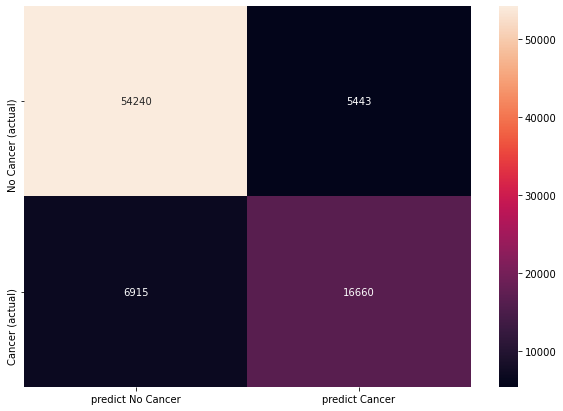

In [42]:
# plot confuction matrix
plt=conf_matrix(model15, x_test, y_test)
plt.show()

## Learnings
- The confusion matrix starts to look better, malicious cells are now classified much less as non-malicious than before
- In the graph above we see that the validation accuracy and loss is decreasing/increasing towards the end
- Train accuracy is now much closer to the validation accuracy (at least for the best epoch) over time they still diverge

Since the training and validatio accuracy are close we can reduce the dropout rate, but at the same time we will add an imageDataGenerator to hopefully increase generalizability of our model.On top we define a learning rate schedule that reduces when a plateau is reached and change all optimizations to from stochastig gradient descent to the adam optimizer.

Since the smaller networks needed more epochs to show improvements we remove the early stopping criterion for those and increase the patience for the rest, to make sure not to stop too early

In [25]:
#Image Data Augmentation

train_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

test_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

val_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

train_generator.fit(x_train)
test_generator.fit(x_test)
val_generator.fit(x_val)

In [26]:
# lower the batch size
batch_size = 512

histories = []

name="1-layer-128-norm-dropout"
print(name)
model17 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model17.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model17.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))


name="2-layer-128-256-norm-dropout"
print(name)
model18 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model18.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model18.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model19 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model19.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model19.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))
hist4 = histories

1-layer-128-norm-dropout
Epoch 1/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.6078 - accuracy: 0.6134 - val_loss: 0.7114 - val_accuracy: 0.2835
Epoch 2/500
4857/4857 [==============================] - 92s 19ms/step - loss: 1.3865 - accuracy: 0.4867 - val_loss: 0.6895 - val_accuracy: 0.7165
Epoch 3/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.3875 - accuracy: 0.4945 - val_loss: 0.6874 - val_accuracy: 0.7165
Epoch 4/500
4857/4857 [==============================] - 92s 19ms/step - loss: 1.3875 - accuracy: 0.4929 - val_loss: 0.6770 - val_accuracy: 0.7165
Epoch 5/500
4857/4857 [==============================] - 92s 19ms/step - loss: 1.3875 - accuracy: 0.4946 - val_loss: 0.6981 - val_accuracy: 0.2835
Epoch 6/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.3875 - accuracy: 0.4857 - val_loss: 0.6895 - val_accuracy: 0.7165: 1.3880 -  - ET
Epoch 7/500
4857/4857 [==============================] - 93s 19ms/step - loss

4857/4857 [==============================] - 94s 19ms/step - loss: 0.9414 - accuracy: 0.8203 - val_loss: 0.4227 - val_accuracy: 0.8433
Epoch 77/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9454 - accuracy: 0.8203 - val_loss: 0.4191 - val_accuracy: 0.8366
Epoch 78/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9435 - accuracy: 0.8209 - val_loss: 0.4815 - val_accuracy: 0.8343
Epoch 79/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9419 - accuracy: 0.8212 - val_loss: 0.4309 - val_accuracy: 0.8444
Epoch 80/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9511 - accuracy: 0.8206 - val_loss: 0.4747 - val_accuracy: 0.8252
Epoch 81/500
4854/4857 [============================>.] - ETA: 0s - loss: 0.9504 - accuracy: 0.8215
Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
4857/4857 [==============================] - 95s 20ms/step - loss: 0.9506 - accuracy: 0.8214 

4857/4857 [==============================] - 93s 19ms/step - loss: 0.9543 - accuracy: 0.8100 - val_loss: 0.6772 - val_accuracy: 0.8091
Epoch 92/500
4857/4857 [==============================] - 92s 19ms/step - loss: 0.9526 - accuracy: 0.8103 - val_loss: 0.4867 - val_accuracy: 0.7970
Epoch 93/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9480 - accuracy: 0.8098 - val_loss: 0.5070 - val_accuracy: 0.7916
Epoch 94/500
4857/4857 [==============================] - 95s 20ms/step - loss: 0.9513 - accuracy: 0.8100 - val_loss: 0.4698 - val_accuracy: 0.7938
Epoch 95/500
4857/4857 [==============================] - 93s 19ms/step - loss: 0.9477 - accuracy: 0.8100 - val_loss: 0.4666 - val_accuracy: 0.8012
Epoch 96/500
4857/4857 [==============================] - 93s 19ms/step - loss: 0.9406 - accuracy: 0.8100 - val_loss: 0.4921 - val_accuracy: 0.7997
Epoch 97/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9465 - accuracy: 0.8079 - val_loss: 0.4873 

In [27]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,1.39,48.67%,0.69,71.65%
2-layer-128-256-norm-dropout,0.94,82.14%,0.39,85.65%
3-layer-512-256-128-norm-dropout,1.01,80.72%,0.41,83.56%


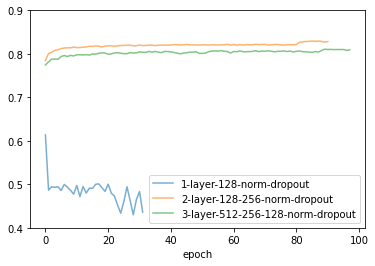

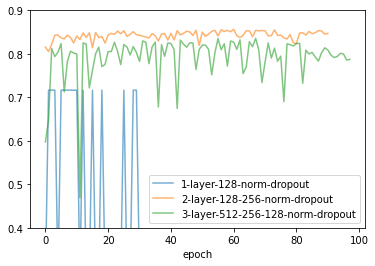

In [44]:
plot_accuracies(hist4, lower_ylim=.4, upper_ylim=.9)

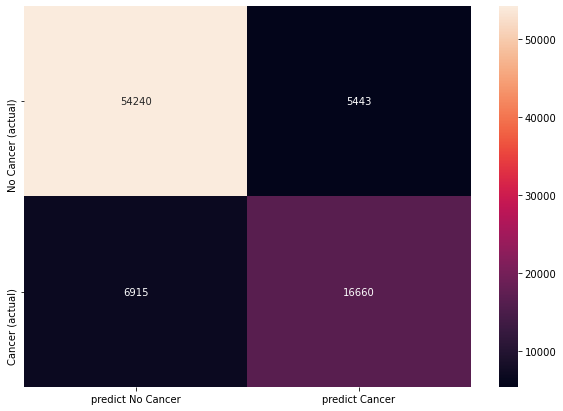

In [45]:
# plot confuction matrix
plt=conf_matrix(model17, x_test, y_test)
plt.show()

# Results

The final model does not seem to be far superior to previous ones if we observe the accuracy and the loss. It has one of the best performances if we measure validation loss and accuracy, but the first model with the learning rate 0.01 reached a similar performance according to those measures.
Since we are building a model for medical diagnosis, accuracy and loss are not neccessarily the most important measures (even though it makes sense to optimize them). including the confusion matrix in our model evaluation shows that we are constantly improving on predicting malicious cells and also minimize the classification of malicious cells as harmless, a missclassification, which could have severe implications for the patient.

Increasing the size of the model to a certain size, adding dropout and normalization layers, countering the imbalance of the data with balanced weights as well as applying a learning rate schedule improved the result significantly.

